# Resting Heart Rate Forecasting

* __Introduction__

    This project explores the use of machine learning methods to forecast resting heart rate. Resting heart rate is the minimum number of times your heart beats per minute while at rest. Generally, for adults, a lower resting heart rate (typically between 60-100 bpm) can indicate a higher degree of physical fitness. Well-trained athletes often have lower resting heart rates because their hearts don't need to work as hard to circulate blood throughout the body.

    Heart rate is influenced by various factors like stress, medication, physical activity, and even temperature. This complexity makes it challenging to pinpoint the exact cause of a specific heart rate reading. However, by analyzing resting heart rate patterns over time, we might gain insights into factors affecting an individual's health or fitness. 
    
    The following two articles from _Harvard Health Publishing_ have great explanation of heart rate,

    1. [What is a normal heart rate?](https://www.health.harvard.edu/heart-health/what-your-heart-rate-is-telling-you)

    1. [Your resting heart rate can reflect your current and future health](https://www.health.harvard.edu/blog/your-resting-heart-rate-can-reflect-your-current-and-future-health-201606172482)

* __Motivation for Forecasting__

    Since resting heart rate is associated with physical fitness, the ability to forecast it could be valuable for athletes or health professionals. For athletes, it could help monitor training effectiveness and the amount of training. For healthcare professionals, it could provide insights into a patient's overall well-being and potential health risks.

* __Our Approach__

    We will approach this as a time series forecasting problem, comparing the performance of linear regression and deep learning models. The project will be divided into four sections:

    1. __Data Preprocessing__: This section will deal with the raw data collected by the device.
    
    2. __Data Cleaning and EDA__: This section will address data cleaning and exploratory data analysis (EDA) to understand the characteristics of the data.
    
    3. __Model Training__: We will train and evaluate several machine learning models for forecasting resting heart rate.

    4. __Model Performance Comparison and Conclusion__: We will compare the performance of the trained models and assess their suitability for this task, and also summarize our findings and discuss potential future directions for this project.

* __Data Description__

    The data for this project consists of daily resting heart rate measurements collected by a smartwatch worn by an amateur runner. The data spans from July 2019 to June 2021, with a gap in May 2020 for unknown reasons. Therefore, we will focus on the data collected from July 2019 to April 2020, which includes 304 daily observations. We will delve deeper into the data details in the following section.

In [1]:
# Packages

# Data process
import numpy as np
import pandas as pd
import re
from pathlib import Path
from datetime import datetime
from feature_engine.datetime import DatetimeFeatures

# Plot
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from matplotlib.colors import rgb2hex
from matplotlib.cm import get_cmap

# Configuration
import warnings
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')
sns.set_context('notebook')
mycolors = {"blue" : "steelblue", 'mid_blue' : '#93a9bd', "red" : "#a76c6e", "green" : "#6a9373", "smoke" : "#f2f2f2"}

In [2]:
# Updating the rcParams in Matplotlib
params = {
    'figure.figsize': [10, 6],
    'font.size': 14,
    'axes.titleweight':'bold',
    'font.family' : 'Lato',
}
plt.rcParams.update(params)
font_t = {'family' : 'Lato', 'color' : '#1f1f1f', 'fontstyle' : 'oblique'}
font_l = {'family' : 'Nunito', 'size' : 14}

In [ ]:
# Plot helper function

# Format the plot title
def format_title(title, subtitle=None, subtitle_font_size=18):
    title = f'<b>{title}</b>'
    if not subtitle:
        return title
    subtitle = f'<span style="font-size: {subtitle_font_size}px;">{subtitle}</span>'
    return f'{title}<br>{subtitle}'

custom_template = {
    "layout": go.Layout(
        font={
            "family": "Nunito",
            "size": 16,
            "color": "#707070",
        },
        title={
            "font": {
                "family": "Lato",
                "size": 26,
                "color": "#1f1f1f",
            },
        },
        plot_bgcolor="#ffffff",
        paper_bgcolor="#ffffff",
        colorway=px.colors.qualitative.G10,
    )
}

# Plotting function
def plot_res(y_train, y_test, y_forecast, y_forecast_train, model_):
    # Plot the forecast.
    fig, ax = plt.subplots(figsize=[10, 6])

    # Plot training set.
    y_train.plot(ax=ax, marker=".")
    # Plot actuals in forecasting horizon.
    y_test.plot(ax=ax, marker=".", alpha=0.6)
    # Plot forecast.
    y_forecast.plot(ax=ax)
    # Plot 1 step forecasts in training data.
    y_forecast_train.plot(ax=ax)

    ax.legend(["train", "test", "forecast", "in-sample forecast"])
    ax.set_xlabel("Time")
    ax.set_ylabel(f"rest_HR")
    ax.set_title(f"Forecast with {model_}")

## <font color = deepskyblue> I. Data Preprocessing</font>

1. __Data introduction__

    There are three different types of data that the smartwatch collects - activity, daily and sleep data. All data points are recorded and calculated daily based on the device's built-in algorithms.

    * Activity data:
    
        Records activity-related information, particularly sports-related metrics, like average running cadence, active calories burned, and distance covered.

    * Daily data: 
    
        Records heart rate and status duration information, including resting heart rate, activity stress duration, and sleep duration.

    * Sleep data: 
    
        Records sleep-related information, such as sleep start time, duration, and stages (deep sleep, light sleep, etc.).

2. __Processing logic__

    For this project, we will focus on the daily and sleep data, excluding activity data. These two datasets can be linked using the date and time columns. Additionally, we will create two new features: `sleep_HR` and `active_HR`, derived from the `timeOffsetHeartRateSamples` column in the daily data.

    * `timeOffsetHeartRateSamples`

        The column contains the user's heart rate readings recorded every 15 throughout the day. There might be missing values due to reasons like the user not wearing the watch or device malfunctions. Any observation where the `durationInSeconds` on the same day isn't 86,400 seconds (24 hours x 60 minutes x 60 seconds) is considered incomplete and will be skipped during processing.

    * `sleep_HR`

        We will compute the average sleeping heart rate (`sleep_HR`) using the `startTimeInSeconds` and `durationInSeconds` columns. These columns indicate when the user goes to sleep and the total sleep duration. We can then extract the corresponding heart rate values from `timeOffsetHeartRateSamples` for the sleep period.  The final `sleep_HR` value will be calculated using the `trim_mean` function from the `scipy` library ([doc](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.trim_mean.html)). We use `trim_mean` to reduce the influence of extreme values and potential measurement errors by excluding a 25 percentage of the highest and lowest readings from the calculation.

    * `active_HR`

        Once we compute `sleep_HR`, it's straightforward to calculate the average active heart rate (`active_HR`). The active period is defined as the time the user is not asleep. We can then extract the corresponding heart rate values from `timeOffsetHeartRateSamples` for this active period. Similar to `sleep_HR`, the final `active_HR` value will be computed using the `trim_mean` function.
    
    * Additional Data

        In addition to the two new features, we also extract the minimum and maximum heart rate values for the day. While these values have potential medical significance, they are not used in this project for simplicity and to focus on the core experiment. These additional features can be explored in future work.

3. __Attributes information__

    After preprocessing, our data will have the following attributes.

    * __date__: Record date

    * __steps__: Total steps taken in a day

    * __sleep_HR__: Average sleeping heart rate

    * __active_HR__: Average active heart rate

    * __rest_HR__: Resting heart rate computed by the device



In [ ]:
# Get all raw data
raw_data = [i for i in Path("./raw_data").glob("*.csv")]
raw_data.sort()
raw_data

In [21]:
# Load raw data
df_daily = pd.read_csv(raw_data[1])
df_sleep = pd.read_csv(raw_data[2])

### <font color = lightskyblue>1. Sleep Data</font>

In [16]:
df_sleep.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2275 entries, 0 to 2274
Data columns (total 12 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   calendarDate                 2275 non-null   object
 1   startTimeInSeconds           2275 non-null   int64 
 2   startTimeOffsetInSeconds     2275 non-null   int64 
 3   durationInSeconds            2275 non-null   int64 
 4   unmeasurableSleepInSeconds   2275 non-null   int64 
 5   deepSleepDurationInSeconds   2275 non-null   int64 
 6   lightSleepDurationInSeconds  2275 non-null   int64 
 7   remSleepInSeconds            2275 non-null   int64 
 8   awakeDurationInSeconds       2275 non-null   int64 
 9   sleepLevelsMap               2275 non-null   object
 10  validation                   2275 non-null   object
 11  timeOffsetSleepSpo2          1825 non-null   object
dtypes: int64(8), object(4)
memory usage: 213.4+ KB


In [11]:
df_sleep.head()

,calendarDate,startTimeInSeconds,startTimeOffsetInSeconds,durationInSeconds,unmeasurableSleepInSeconds,deepSleepDurationInSeconds,lightSleepDurationInSeconds,remSleepInSeconds,awakeDurationInSeconds,sleepLevelsMap,validation,timeOffsetSleepSpo2
0,2018-12-20,1545228060,28800,0,0,0,0,0,0,NaN,ENHANCED_FINAL,NaN
1,2018-12-21,1545318300,28800,0,0,0,0,0,0,NaN,ENHANCED_TENTATIVE,NaN
2,2018-12-22,1545402360,28800,0,0,0,0,0,0,NaN,ENHANCED_TENTATIVE,NaN
3,2018-12-23,1545489900,28800,0,0,0,0,0,0,NaN,ENHANCED_FINAL,NaN
4,2018-12-24,1545575760,28800,0,0,0,0,0,0,NaN,ENHANCED_TENTATIVE,NaN


In [35]:
# Select only wanted columns
cols = ['calendarDate', 'startTimeInSeconds', 'startTimeOffsetInSeconds', 'durationInSeconds',]

# Create an empty df
df = pd.DataFrame()

# Load each sleep data
for path in raw_data:
    if "sleeps" in path.as_posix():
        # Read data
        df_temp = pd.read_csv(path, parse_dates = ['calendarDate'], usecols = cols,)

        # Extract year and month
        df_temp['year'] = pd.Series([ele.date().year for ele in df_temp['calendarDate']], dtype = 'category')
        df_temp['month'] = pd.Series([ele.date().month for ele in df_temp['calendarDate']], dtype = 'category')

        # Drop the duplicated data and extract
        df_temp.sort_values(by = 'calendarDate', inplace = True, ignore_index = True)
        df_temp.drop_duplicates(subset = 'calendarDate', keep = 'last', inplace = True, ignore_index = True)
        
        # Concatenation
        if len(df) == 0:
            df = pd.concat([df, df_temp], ignore_index=True)
        else:
            df = pd.concat([df, df_temp], join='inner', ignore_index=True) # set join='inner' to avoid duplicates
        
# Save the cleaned sleep data
df.drop_duplicates(subset = 'calendarDate', keep = 'last', inplace = True, ignore_index = True)
df.to_csv('cleaned_sleep_data.csv', index = False)


In [23]:
# Load
df_sleep = pd.read_csv('cleaned_sleep_data.csv', parse_dates=['calendarDate'],)
df_sleep.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 903 entries, 0 to 902
Data columns (total 6 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   calendarDate              903 non-null    datetime64[ns]
 1   startTimeInSeconds        903 non-null    int64         
 2   startTimeOffsetInSeconds  903 non-null    int64         
 3   durationInSeconds         903 non-null    int64         
 4   year                      903 non-null    int64         
 5   month                     903 non-null    int64         
dtypes: datetime64[ns](1), int64(5)
memory usage: 42.5 KB


### <font color = lightskyblue>2. Daily Data</font>

In [24]:
df_daily.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 738 entries, 0 to 737
Data columns (total 32 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   calendarDate                        738 non-null    object 
 1   startTimeInSeconds                  738 non-null    int64  
 2   startTimeOffsetInSeconds            738 non-null    int64  
 3   activityType                        738 non-null    object 
 4   durationInSeconds                   738 non-null    int64  
 5   steps                               738 non-null    int64  
 6   distanceInMeters                    738 non-null    int64  
 7   activeTimeInSeconds                 738 non-null    int64  
 8   activeKilocalories                  738 non-null    int64  
 9   bmrKilocalories                     737 non-null    float64
 10  consumedCalories                    0 non-null      float64
 11  moderateIntensityDurationInSeconds  737 non-n

In [25]:
# Data preview
df_daily.head()

,calendarDate,startTimeInSeconds,startTimeOffsetInSeconds,activityType,durationInSeconds,steps,distanceInMeters,activeTimeInSeconds,activeKilocalories,bmrKilocalories,consumedCalories,moderateIntensityDurationInSeconds,vigorousIntensityDurationInSeconds,floorsClimbed,minHeartRateInBeatsPerMinute,averageHeartRateInBeatsPerMinute,maxHeartRateInBeatsPerMinute,restingHeartRateInBeatsPerMinute,timeOffsetHeartRateSamples,averageStressLevel,maxStressLevel,stressDurationInSeconds,restStressDurationInSeconds,activityStressDurationInSeconds,lowStressDurationInSeconds,mediumStressDurationInSeconds,highStressDurationInSeconds,stressQualifier,stepsGoal,netKilocaloriesGoal,intensityDurationGoalInSeconds,floorsClimbedGoal
0,2018-12-16,1544889600,28800,WALKING,86400,0,110480,0,2037,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2018-12-19,1545148800,28800,WALKING,86400,513,401,659,53,1830.0,NaN,0.0,0.0,1.0,NaN,NaN,NaN,48.0,NaN,12.0,95.0,1320.0,8460.0,420.0,360.0,420.0,540.0,unknown,10000.0,NaN,9000.0,10.0
2,2018-12-20,1545235200,28800,WALKING,86400,11339,9999,15307,1002,1827.0,NaN,2340.0,6540.0,9.0,NaN,NaN,NaN,47.0,NaN,42.0,98.0,30900.0,24960.0,17580.0,6180.0,11220.0,13500.0,stressful,10000.0,NaN,9000.0,10.0
3,2018-12-21,1545321600,28800,WALKING,86400,15203,13084,13896,1367,1827.0,NaN,6780.0,10080.0,10.0,NaN,NaN,NaN,52.0,NaN,37.0,98.0,19020.0,30420.0,22020.0,3360.0,5640.0,10020.0,balanced,10140.0,NaN,9000.0,10.0
4,2018-12-22,1545408000,28800,WALKING,86400,19989,18552,15483,1282,1814.0,NaN,3060.0,8520.0,9.0,NaN,NaN,NaN,55.0,NaN,48.0,99.0,33840.0,22140.0,18000.0,5040.0,11760.0,17040.0,stressful,11160.0,NaN,9000.0,10.0


In [14]:
# Load cleaned sleep data
df_sleep = pd.read_csv('cleaned_sleep_data.csv',)

from datetime import datetime

cols  = [
    'calendarDate', 'startTimeInSeconds', 'startTimeOffsetInSeconds', 'activityType','durationInSeconds', 
    'steps', 'distanceInMeters', 'activeTimeInSeconds', 'activeKilocalories', 'bmrKilocalories',
    'moderateIntensityDurationInSeconds','vigorousIntensityDurationInSeconds','floorsClimbed', 'minHeartRateInBeatsPerMinute',
    'averageHeartRateInBeatsPerMinute', 'maxHeartRateInBeatsPerMinute', 'restingHeartRateInBeatsPerMinute',
    'timeOffsetHeartRateSamples', 'averageStressLevel', 'maxStressLevel', 'stressDurationInSeconds', 
    'restStressDurationInSeconds', 'activityStressDurationInSeconds', 'lowStressDurationInSeconds',
    'mediumStressDurationInSeconds', 'highStressDurationInSeconds', 'stressQualifier', 'netKilocaloriesGoal',
    'intensityDurationGoalInSeconds', 'floorsClimbedGoal']

# Load data for dailies data and we deal with each of them seperately 
for path in raw_data:
    if "dailies" in path.as_posix():

        df_daily = pd.read_csv(path, usecols = cols, )
        # Drop any NaN data in timeOffsetHeartRateSamples
        df_daily.dropna(axis = 0, subset = 'timeOffsetHeartRateSamples', inplace = True)

        # And we don't want the data that is incomplete as well as the duplicate dates
        df_daily = df_daily[df_daily['durationInSeconds'] == 86400].copy()
        df_daily.drop_duplicates(subset = ['calendarDate'], ignore_index = True, inplace = True)

        # We only need the data during that year
        year = path.as_posix()[9:13]
        # df_daily = df_daily.query("calendarDate > datetime("+ str(int(year)-1) +",12,31) and calendarDate < datetime("+ str(int(year)+1) +",1,1)", engine='python')
        df_daily = df_daily.loc[(df_daily["calendarDate"] > f"{int(year)-1}-12-31") & (df_daily["calendarDate"] < f"{int(year)+1}-01-01")]

        # Sort the dataframe by date, and reset index
        df_daily.sort_values(by = ['calendarDate'], ignore_index = True, inplace = True)
        df_daily.reset_index(drop = True, inplace = True)
        
        print(f"Daily data: {df_daily.shape}")   
        
        # Using merge, inner join method on 'calendarDate' to match the data on the same date
        df_merge = df_daily.merge(df_sleep, how = 'inner', on = 'calendarDate', suffixes = ['_daily', '_sleep'])
        print(f"Merged data: {df_merge.shape}")
        
        # Add a new column for sleep date
        df_merge['sleep_date'] = df_merge['startTimeInSeconds_sleep'].apply(lambda x: datetime.fromtimestamp(x))

Daily data: (183, 31)
Merged data: (183, 36)
Daily data: (335, 31)
Merged data: (381, 36)
Daily data: (168, 31)
Merged data: (165, 36)


### <font color = lightskyblue>3.Data integration</font>

In [39]:
from scipy.stats import trim_mean
import json
# Define a function for computing sleepHR & activeHR
def sleep_hr(path, year):
    
    # Load cleaned sleep data
    df_sleep = pd.read_csv('cleaned_sleep_data.csv', header = 0, parse_dates = ['calendarDate'])
    
    ### Load Data for dailies data and we deal with each of them seperately 
    
    # Skip 'userAccessToken', 'summaryId', 'consumedCalories', 'stepsGoal', 
    cols  = ['userId', 'calendarDate', 'startTimeInSeconds', 'startTimeOffsetInSeconds', 'activityType','durationInSeconds', 
             'steps', 'distanceInMeters', 'activeTimeInSeconds', 'activeKilocalories', 'bmrKilocalories',
             'moderateIntensityDurationInSeconds','vigorousIntensityDurationInSeconds','floorsClimbed', 'minHeartRateInBeatsPerMinute',
             'averageHeartRateInBeatsPerMinute', 'maxHeartRateInBeatsPerMinute', 'restingHeartRateInBeatsPerMinute',
             'timeOffsetHeartRateSamples', 'averageStressLevel', 'maxStressLevel', 'stressDurationInSeconds', 
             'restStressDurationInSeconds', 'activityStressDurationInSeconds', 'lowStressDurationInSeconds',
             'mediumStressDurationInSeconds', 'highStressDurationInSeconds', 'stressQualifier', 'netKilocaloriesGoal',
             'intensityDurationGoalInSeconds', 'floorsClimbedGoal']

    df_daily = pd.read_csv(path, 
                           usecols = cols,
                           header = 0, parse_dates = ['calendarDate'], )

    # Drop any NaN data in timeOffsetHeartRateSamples
    df_daily.dropna(axis = 0, subset = 'timeOffsetHeartRateSamples', inplace = True)

    # And we don't want the data that is incomplete as well as the duplicate dates
    df_daily = df_daily[df_daily['durationInSeconds'] == 86400].copy()
    df_daily.drop_duplicates(subset = ['calendarDate'], ignore_index = True, inplace = True)

    # We only need the data during that year
    df_daily = df_daily.loc[(df_daily["calendarDate"] > f"{int(year)-1}-12-31") & (df_daily["calendarDate"] < f"{int(year)+1}-01-01")]


    # Sort the dataframe by date, and reset index
    df_daily.sort_values(by = ['calendarDate'], ignore_index = True, inplace = True)
    df_daily.reset_index(drop = True, inplace = True)
    
    print(f"Daily data: {df_daily.shape}")   
    
    # Using merge, inner join method on 'calendarDate' to match the data on the same date
    df_merge = df_daily.merge(df_sleep, how = 'inner', on = 'calendarDate', suffixes = ['_daily', '_sleep'])
    print(f"Merged data: {df_merge.shape}")
    
    # Add a new column for sleep date
    df_merge['sleep_date'] = df_merge['startTimeInSeconds_sleep'].apply(lambda x: datetime.fromtimestamp(x))
    
    ### Compute sleep heart rate

    # Initialize each sleeping HR varibles
    sleepHR = [0]*len(df_merge)
    trim_meanSleepHR = [0]*len(df_merge)
    maxSleepHR = [0]*len(df_merge)
    minSleepHR = [0]*len(df_merge)

    # Set varibles for computation
    start_sleep_time = df_merge['sleep_date']
    date = df_merge['calendarDate']
    total_sleep_sec = df_merge['durationInSeconds_sleep']
    hr = df_merge['timeOffsetHeartRateSamples']

    # To see if the first record is useful or not
    if date[0].day == start_sleep_time[0].day:
        start = 0
    else:
        start = 1
        
    # Compute sleeping HR    
    for i in range(start, len(df_merge)):

        sleep_time = start_sleep_time[i]

        today_hr = json.loads(hr[i])

        # Same day
        if date[i].day == sleep_time.day:

            today_sec = (sleep_time.hour*3600) + (sleep_time.minute*60)

            today_day_hr_list = [ today_hr[str(j)] for j in range(today_sec, (total_sleep_sec[i]+today_sec+15), 15) if str(j) in today_hr]        

            # If the watch didn't record the hr data during sleep, it will cause error 
            if today_day_hr_list == []: continue

            sleepHR[i] = np.mean(today_day_hr_list, dtype = np.int64)
            
            trim_meanSleepHR[i] = trim_mean(today_day_hr_list, 0.25)

            maxSleepHR[i] = np.max(today_day_hr_list)

            minSleepHR[i] = np.min(today_day_hr_list)

        # Cross a day
        else: 

            last_day_hr = json.loads(hr[i-1])

            last_day_sec = ((23 - sleep_time.hour)*3600) + ((60 - sleep_time.minute)*60)

            today_sec = total_sleep_sec[i] - last_day_sec

            last_day_hr_list = [ last_day_hr[str(j)] for j in range((86415-last_day_sec), 86415, 15) if str(j) in last_day_hr]

            today_day_hr_list = [ today_hr[str(j)] for j in range(15, today_sec+15, 15) if str(j) in today_hr]        

            total = last_day_hr_list + today_day_hr_list

            # If the watch didn't record the hr data during sleep, it will cause error 
            if total ==[]: continue

            sleepHR[i] = np.mean(total, dtype = np.int64)
            
            trim_meanSleepHR[i] = trim_mean(total, 0.25)

            maxSleepHR[i] = np.max(total)

            minSleepHR[i] = np.min(total)   

    # Insert it into the dataframe
    df_merge['sleepHR'] = pd.Series(sleepHR)
    df_merge['trim_meanSleepHR'] = pd.Series(trim_meanSleepHR)
    df_merge['maxSleepHR'] = pd.Series(maxSleepHR)
    df_merge['minSleepHR'] = pd.Series(minSleepHR)    
    
    ### Compute active heart rate

    # Initialize each active HR varibles
    activeHR = [0]*len(df_merge)
    trim_meanActiveHR = [0]*len(df_merge)
    maxActiveHR = [0]*len(df_merge)
    minActiveHR = [0]*len(df_merge)
    
    # Set varibles for computation
    start_sleep_time = df_merge['sleep_date']
    date = df_merge['calendarDate']
    total_sleep_sec = df_merge['durationInSeconds_sleep']
    hr = df_merge['timeOffsetHeartRateSamples']

    # Compute Active HR
    # To see if the first record is useful or not
    if date[0].day == start_sleep_time[0].day:
        start = 0
    else:
        start = 1
    
    for i in range(start, len(df_merge)-1):

        sleep_time = start_sleep_time[i]    
        today_hr = json.loads(hr[i])

        # Same day
        if date[i].day == sleep_time.day:

            today_sleep_sec = (sleep_time.hour*3600) + (sleep_time.minute*60) + total_sleep_sec[i]

            today_sleep = start_sleep_time[i+1]
            
            if today_sleep.day == (date[i].day) +1:
    
                active_end = 86400
            else:
                active_end = (today_sleep.hour*3600) + (today_sleep.minute*60)

            today_day_hr_list = [ today_hr[str(j)] for j in range((today_sleep_sec+15), active_end, 15) if str(j) in today_hr]        

            # If the watch didn't record the hr data during sleep, it will cause error 
            if today_day_hr_list ==[]: 
                continue

            # Compute Active HR
            activeHR[i] = np.mean(today_day_hr_list, dtype = np.int64)            
            trim_meanActiveHR[i] = trim_mean(today_day_hr_list, 0.25)
            maxActiveHR[i] = np.max(today_day_hr_list)
            minActiveHR[i] = np.min(today_day_hr_list)

        # Cross a day 
        else: #date[i].day == (sleep_time.day)+1:
            
            last_day_hr = json.loads(hr[i-1])

            last_day_sec = ((23 - sleep_time.hour)*3600) + ((60 - sleep_time.minute)*60)

            today_sec = total_sleep_sec[i] - last_day_sec

            today_sleep = start_sleep_time[i+1]
            
            if today_sleep.day == (date[i].day) +1:
    
                active_end = 86400
            else:
                active_end = (today_sleep.hour*3600) + (today_sleep.minute*60)

            active_end = (today_sleep.hour*3600) + (today_sleep.minute*60)

            today_day_hr_list = [ today_hr[str(j)] for j in range(today_sec+15, active_end, 15) if str(j) in today_hr]        

            # If the watch didn't record the hr data during sleep, it will cause error 
            if today_day_hr_list ==[]:
                continue

            # Compute Active HR
            activeHR[i] = np.mean(today_day_hr_list, dtype = np.int64)            
            trim_meanActiveHR[i] = trim_mean(today_day_hr_list, 0.25)
            maxActiveHR[i] = np.max(today_day_hr_list)
            minActiveHR[i] = np.min(today_day_hr_list)

        # If there are missing date values, we skip it.    
        # else:
        #     continue

    # Insert it into the dataframe
    df_merge['activeHR'] = pd.Series(activeHR)
    df_merge['trim_meanActiveHR'] = pd.Series(trim_meanActiveHR)
    df_merge['maxActiveHR'] = pd.Series(maxActiveHR)
    df_merge['minActiveHR'] = pd.Series(minActiveHR)
    
    
    print(f"Final Data Shape: {df_merge.shape}")
    # Save the processed data
    df_merge.to_csv(f'./cleaned_dailies_{year}.csv', index = False)
    

In [40]:
## Compute sleepHR/activeHR
for path in raw_data:
    if "dailies" in path.as_posix():
        year = path.as_posix()[9:13]
        sleep_hr(path, year)       

Daily data: (183, 31)
Merged data: (183, 36)
Final Data Shape: (183, 46)
Daily data: (335, 31)
Merged data: (323, 36)
Final Data Shape: (323, 46)
Daily data: (168, 31)
Merged data: (165, 36)
Final Data Shape: (165, 46)


In [39]:
cleaned_data = [i for i in Path('./').glob('c*.csv')]
cleaned_data.sort()
cleaned_data

[PosixPath('cleaned_dailies_2019.csv'),
 PosixPath('cleaned_dailies_2020.csv'),
 PosixPath('cleaned_dailies_2021.csv'),
 PosixPath('cleaned_sleep_data.csv')]

In [44]:
### Concatenate dailies data
# Create an empyt df
df = pd.DataFrame()
for path in cleaned_data[:3]:

    data = pd.read_csv(path)

    df = pd.concat([df, data], ignore_index = True)
    
# Delete the data that contains incomplete hr data
index = df[df['sleepHR']==0].index

df_final = df.drop(index)
df_final = df_final.drop(['netKilocaloriesGoal'], axis = 1)
df_final.reset_index(drop = True, inplace = True)

# Save the final data
df_final.to_csv('./integrated_data.csv', index = False)

# Final shape
print(f"Final data shape: {df_final.shape} [N/A values: {df_final.isna().sum().sum()}]")

Final data shape: (666, 45) [N/A values: 0]


## <font color = deepskyblue>II. Data Cleaning and EDA</font>

In [46]:
# available_features 
     # ['calendarDate', 'steps', 'minHeartRateInBeatsPerMinute', 'averageHeartRateInBeatsPerMinute', 'maxHeartRateInBeatsPerMinute',
     # 'restingHeartRateInBeatsPerMinute', 'year', 'month', 'sleepHR', 'trim_meanSleepHR', 'maxSleepHR', 'minSleepHR',
     # 'activeHR', 'trim_meanActiveHR', 'maxActiveHR', 'minActiveHR', 'nextDayRestHR', 'timeOffsetHeartRateSamples']

# We are interested in the following features
selected_features = ['calendarDate', 'steps', 'trim_meanSleepHR', 'trim_meanActiveHR', 'restingHeartRateInBeatsPerMinute', ]
# Load data
df = pd.read_csv(
     "./integrated_data.csv", 
     usecols=selected_features, 
     parse_dates=['calendarDate'], 
     )

target_ = 'rest_HR'
fs = ['steps', 'sleep_HR', 'active_HR']
# Rename columns
df.rename({'calendarDate' : 'date', 'trim_meanSleepHR' : 'sleep_HR', 'trim_meanActiveHR' : 'active_HR', 'restingHeartRateInBeatsPerMinute' : target_}, axis=1, inplace=True)
display(df.head())
display(df.info())

,date,steps,rest_HR,sleep_HR,active_HR
0,2019-07-02,4649,53.0,52.581699,91.736497
1,2019-07-03,18921,51.0,52.781553,90.043272
2,2019-07-04,4450,48.0,49.488814,96.958359
3,2019-07-05,23833,48.0,51.916493,89.613564
4,2019-07-06,4015,48.0,48.940379,79.569532


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 666 entries, 0 to 665
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       666 non-null    datetime64[ns]
 1   steps      666 non-null    int64         
 2   rest_HR    666 non-null    float64       
 3   sleep_HR   666 non-null    float64       
 4   active_HR  666 non-null    float64       
dtypes: datetime64[ns](1), float64(3), int64(1)
memory usage: 26.1 KB


None

### <font color = lightskyblue>1. Outlier Detection and Treatment</font>

The data contains potential outliers in two key features: heart rate related (`_HR`) and `steps`. 

* **Heart Rate:** We identified two types of outliers for heart rate: values of zero and values exceeding 220 beats per minute (bpm). 
    * A heart rate of zero is physiologically impossible. 

    * Values exceeding 220 bpm are extremely rare for adults during moderate activity levels or even during exercising.

* **Steps:**  While it's possible to have zero steps for a short period, it's highly unlikely for daily recordings within our study. 

**Outlier Treatment Strategy**

To address these outliers, we implemented the following approach:

1. **Replacing Extreme Values:**

    * We replaced heart rates of zero and step counts of zero with `np.nan`. This approach avoids introducing artificial values while preserving information about the missing data points.
    
    * We capped heart rates exceeding 220 bpm at 220 bpm. This acknowledges the physiological limitations of heart rate and prevents these values from disproportionately influencing our analysis. 

2. **Forward Filling for Time Series Decomposition (Next Step):** 
    
    We will utilize forward filling to replace the `np.nan` values introduced in step 1. This is a temporary step to facilitate time series decomposition in the next part of our analysis.

3. **Better Filling Methord For NAs (Part Three):** 
    
    In a later stage (part three), we will revisit these replaced values (originally zero HR or steps) to see if we could fill them with more reasonable values.

In [5]:
# Treat 0 as NA first
df['active_HR'][df['active_HR'] == 0] = np.nan
df['sleep_HR'][df['sleep_HR'] == 0] = np.nan
df['steps'][df['steps'] == 0] = np.nan
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 666 entries, 0 to 665
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       666 non-null    datetime64[ns]
 1   steps      665 non-null    float64       
 2   rest_HR    666 non-null    float64       
 3   sleep_HR   666 non-null    float64       
 4   active_HR  636 non-null    float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 26.1 KB


In [6]:
## Double check if there are outliers
# List to store the index of outlier
index = []
# Check HR data first
for i in df.filter(like=f"_HR").columns:
    # Check if heart rate = 0
    i_ = df[df[i] == 0].index.to_list()
    print(f"{len(i_)} zeros in {i}")
    index += i_
    # Check abnormal heart rates
    i_ = df[df[i] >= 220].index.to_list()
    print(f"{len(i_)} over 220 in {i}")
    if i_ != 0:
        # Replace abnormal heart rate as 220 bpm
        df[i].mask(df[i]>= 220, other = 220, inplace = True)
i_ = df[df['steps'] == 0].index
print(f"{len(i_)} zeros in steps")
index += i_
print(f"Total outliers: {len(index)}")

0 zeros in rest_HR
0 over 220 in rest_HR
0 zeros in sleep_HR
0 over 220 in sleep_HR
0 zeros in active_HR
0 over 220 in active_HR
0 zeros in steps
Total outliers: 0


In [7]:
# Set date as index
df_d = df.set_index('date').asfreq('D')
# Only use subset of the data
df_d = df_d[df_d.index <= '20200430'].copy()
# Number if there are NAs in each column
df_d.isnull().sum()

steps         7
rest_HR       7
sleep_HR      7
active_HR    21
dtype: int64

In [8]:
# Use forward filling NAs first
df_imputed = df_d.fillna(method='ffill')
df_imputed.isnull().sum()

steps        0
rest_HR      0
sleep_HR     0
active_HR    0
dtype: int64

### <font color = lightskyblue>2. Time Series Decomposition</font>

Since our data exhibits non-stationary characteristics, and to better capture useful seasonalities, we will perform `LOWESS` as well as `Box-Cox transformation` on both features and the target variable. 

**Detrending and Variance Stabilization**

1. **LOWESS (Locally Weighted Scatterplot Smoothing):** We will employ LOWESS to estimate the underlying trend of each time series. This method provides a flexible way to capture smooth, non-linear trend within the data.

2. **Box-Cox Transformation:** This transformation helps to stabilize the variance and improve the normality of the data.

**Seasonality Analysis**

1. **PACF (Partial Autocorrelation Function):** 

    <u>We will compute the PACF for the original series, detrended series, and Box-Cox transformed series</u> and plot the results. The PACF helps identify significant lags in the data that might indicate seasonality. By analyzing the PACF plots for all three versions of the data, we can gain a more comprehensive understanding of the seasonality present.

2. **Seasonality Selection:** 

    Based on the PACF analysis and the expected characteristics of heart rate data, we will select the most relevant seasonal lags. The lags below five periods are excluded, as these are unlikely to represent meaningful seasonality for heart rate data.

3. **STL or MSTL Decomposition:** 

    Finally, we will utilize the identified seasonality to decompose the original data using either the `STL` or `MSTL` function. This decomposition separates the data into trend, seasonal components, and residuals. We can have a better understanding of the series by examing these components, and also see if the parameters of the functions need to be adjusted. For more information related to the two functions, please refer to the official document, [STL](https://www.statsmodels.org/dev/examples/notebooks/generated/stl_decomposition.html#Forecasting-with-STL), [MSTL](https://www.statsmodels.org/dev/examples/notebooks/generated/mstl_decomposition.html).

This two-step approach of detrending and variance stabilization followed by seasonality analysis ensures we effectively capture the underlying structure of the time series data and prepare it for further modeling and missing data imputation. 

In [9]:
# Packages
from scipy.stats import boxcox 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.seasonal import STL, MSTL
from statsmodels.nonparametric.smoothers_lowess import lowess

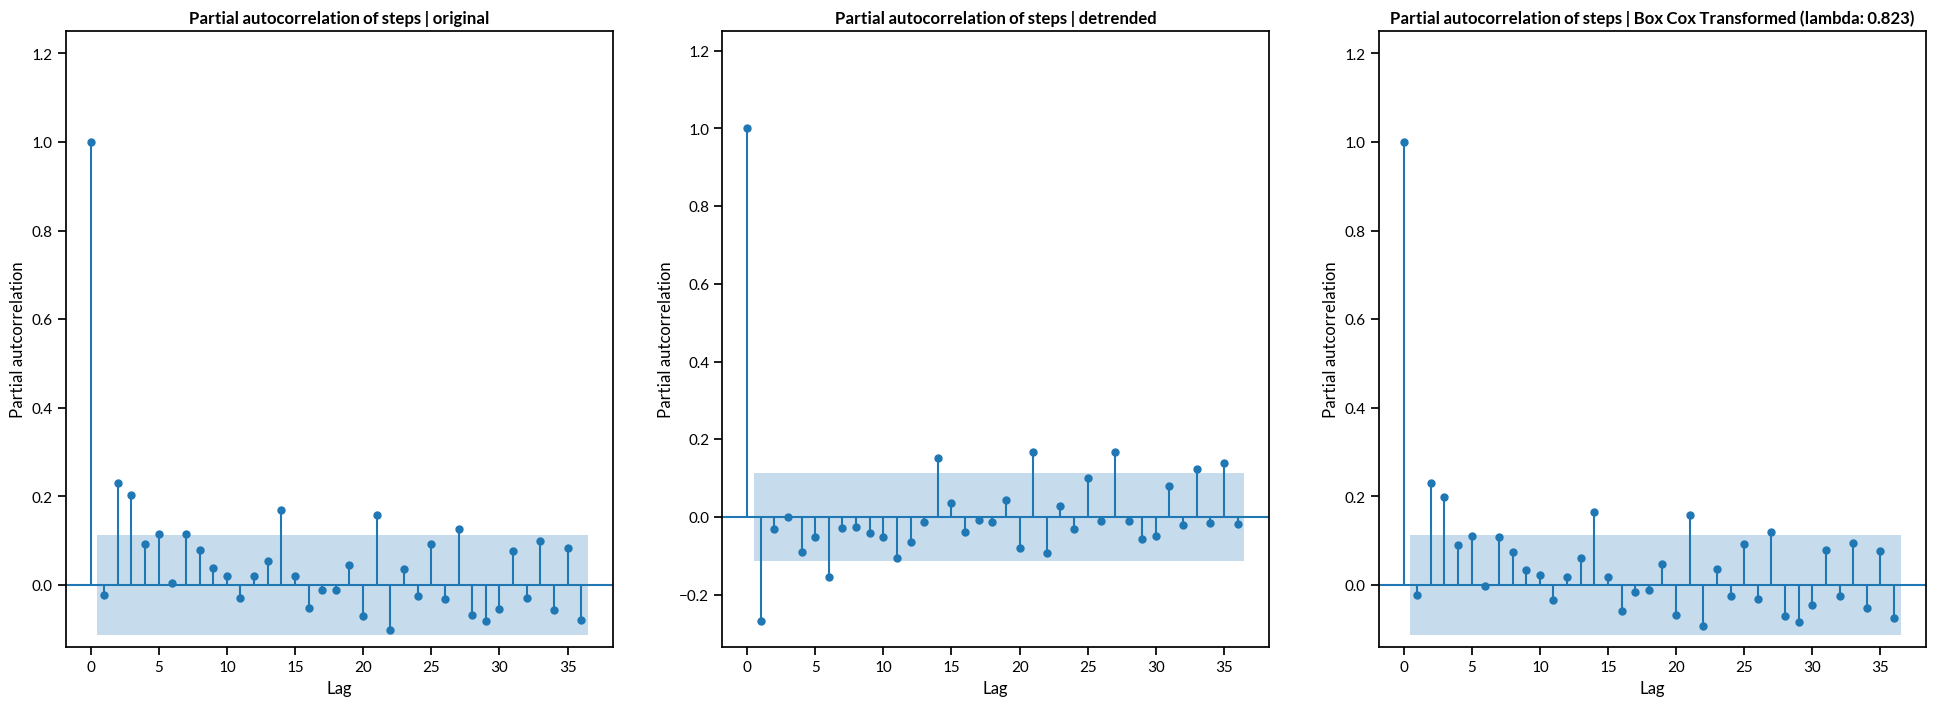

In [10]:
x = df_imputed['steps']

# Compute the trend with LOWESS
res = lowess(endog=x, exog=np.arange(len(x)), frac=.1)
x_lowess = x - res[:, 1]

# Perform Box-Cox transformation on original data
transformed_data, best_lambda = boxcox(x) 
x_box_cox = transformed_data

# Check seasonality by PACF
fig, ax = plt.subplots(ncols=3, figsize=[24, 8], sharex=True)
for i, n, x_ in zip(range(3), ['original', 'detrended', f'Box Cox Transformed (lambda: {best_lambda:.3f})'], [x, x_lowess, x_box_cox]):
    plot_pacf(
        x=x_,
        lags=36,
        ax=ax[i],
        alpha=0.05,
        auto_ylims=True
    )
    ax[i].set_title(f"Partial autocorrelation of steps | {n}")
    ax[i].set_ylabel("Partial autcorrelation")
    ax[i].set_xlabel("Lag");

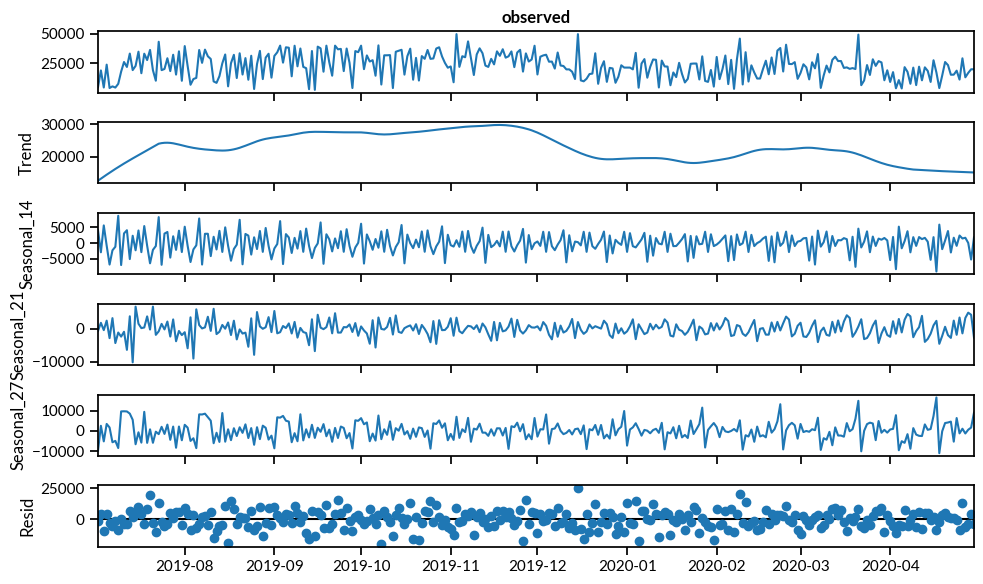

In [11]:
# Break the timeseries into trend, seasonality, and residual components
res_step = MSTL(
    x,
    periods=[14, 21, 27], # 2, 3, 5, 7, 
    windows=[61]*3,
    ).fit()

# Plot the full decomposition
res_step.plot();

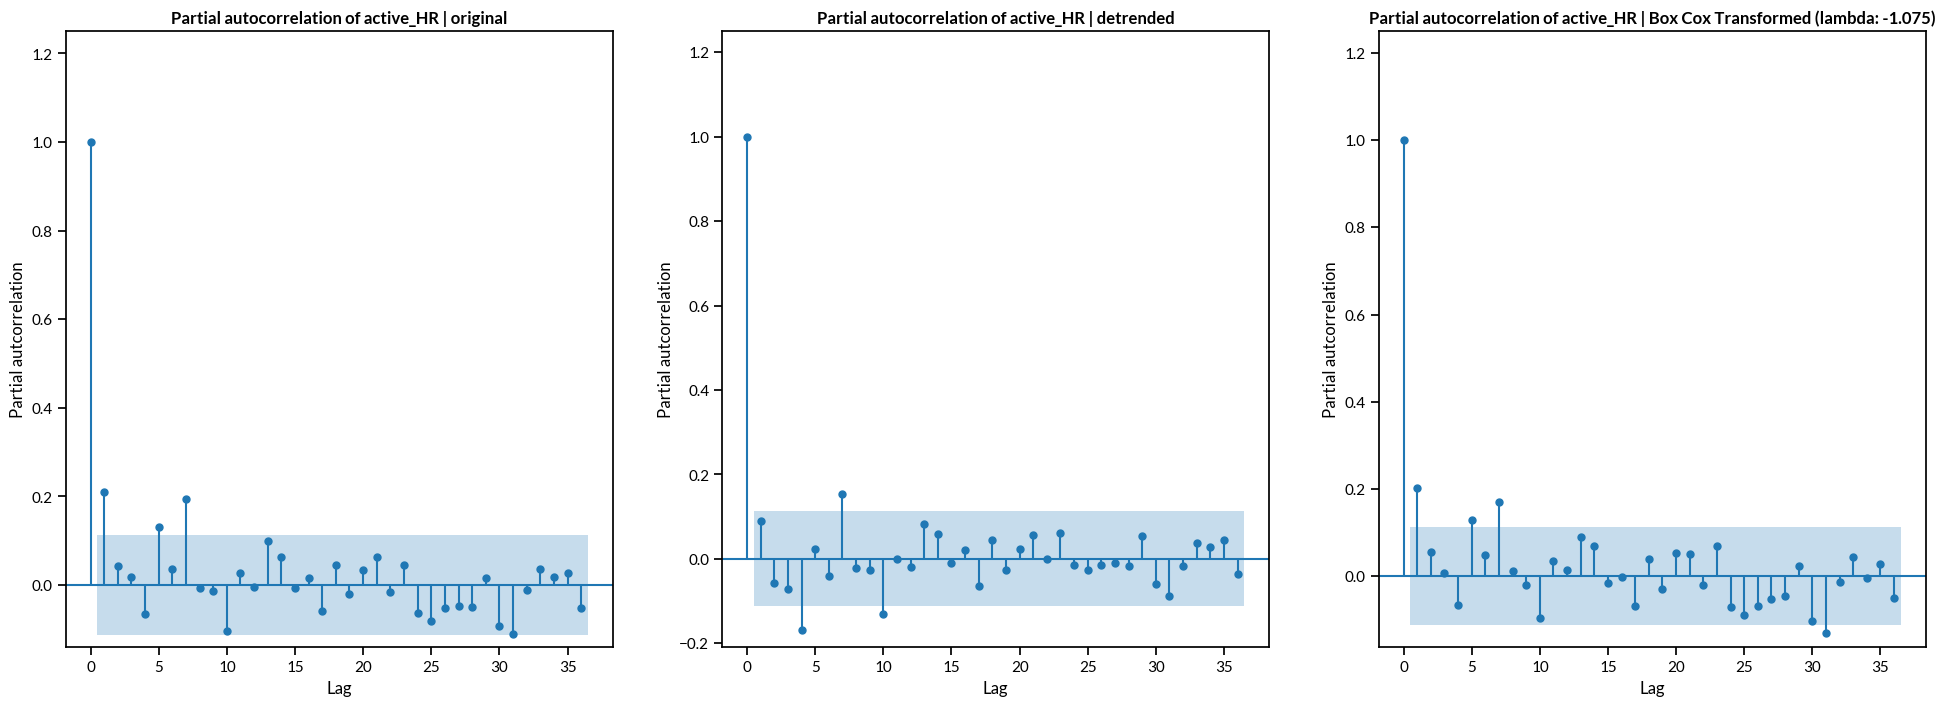

In [12]:
x = df_imputed['active_HR']

# Compute the trend with LOWESS
res = lowess(endog=x, exog=np.arange(len(x)), frac=.1)
x_lowess = x - res[:, 1]

# Perform Box-Cox transformation on original data
transformed_data, best_lambda = boxcox(x) 
x_box_cox = transformed_data

# Check seasonality by PACF
fig, ax = plt.subplots(ncols=3, figsize=[24, 8], sharex=True)
for i, n, x_ in zip(range(3), ['original', 'detrended', f'Box Cox Transformed (lambda: {best_lambda:.3f})'], [x, x_lowess, x_box_cox]):
    plot_pacf(
        x=x_,
        lags=36,
        ax=ax[i],
        alpha=0.05,
        auto_ylims=True
    )
    ax[i].set_title(f"Partial autocorrelation of active_HR | {n}")
    ax[i].set_ylabel("Partial autcorrelation")
    ax[i].set_xlabel("Lag");

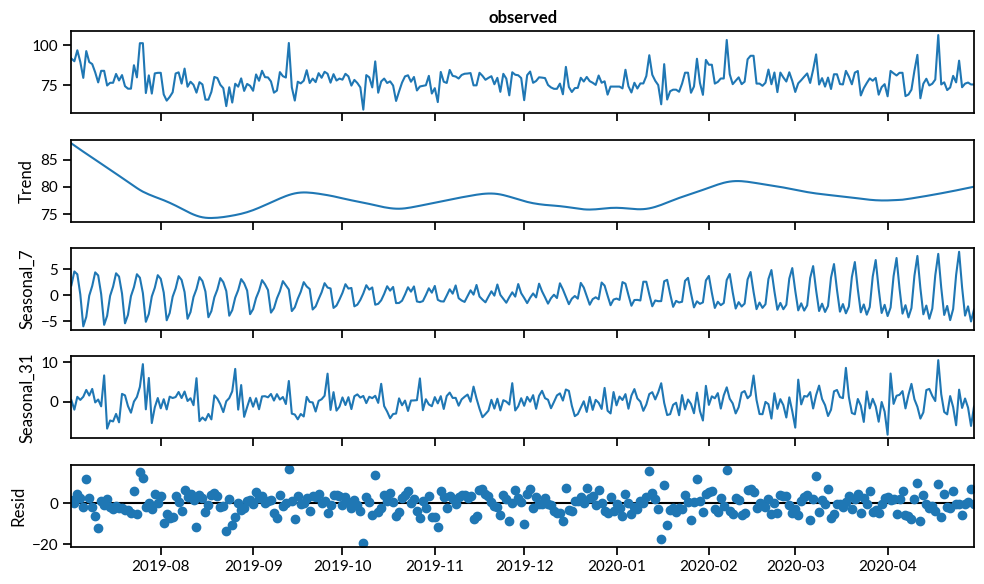

In [13]:
# Break the timeseries into trend, seasonality, and residual components
res_active_HR = MSTL(
    x,
    periods=[7, 31], # periods=[5, 7, 31]
    windows=[61, 61],
    ).fit()

# Plot the full decomposition
res_active_HR.plot();

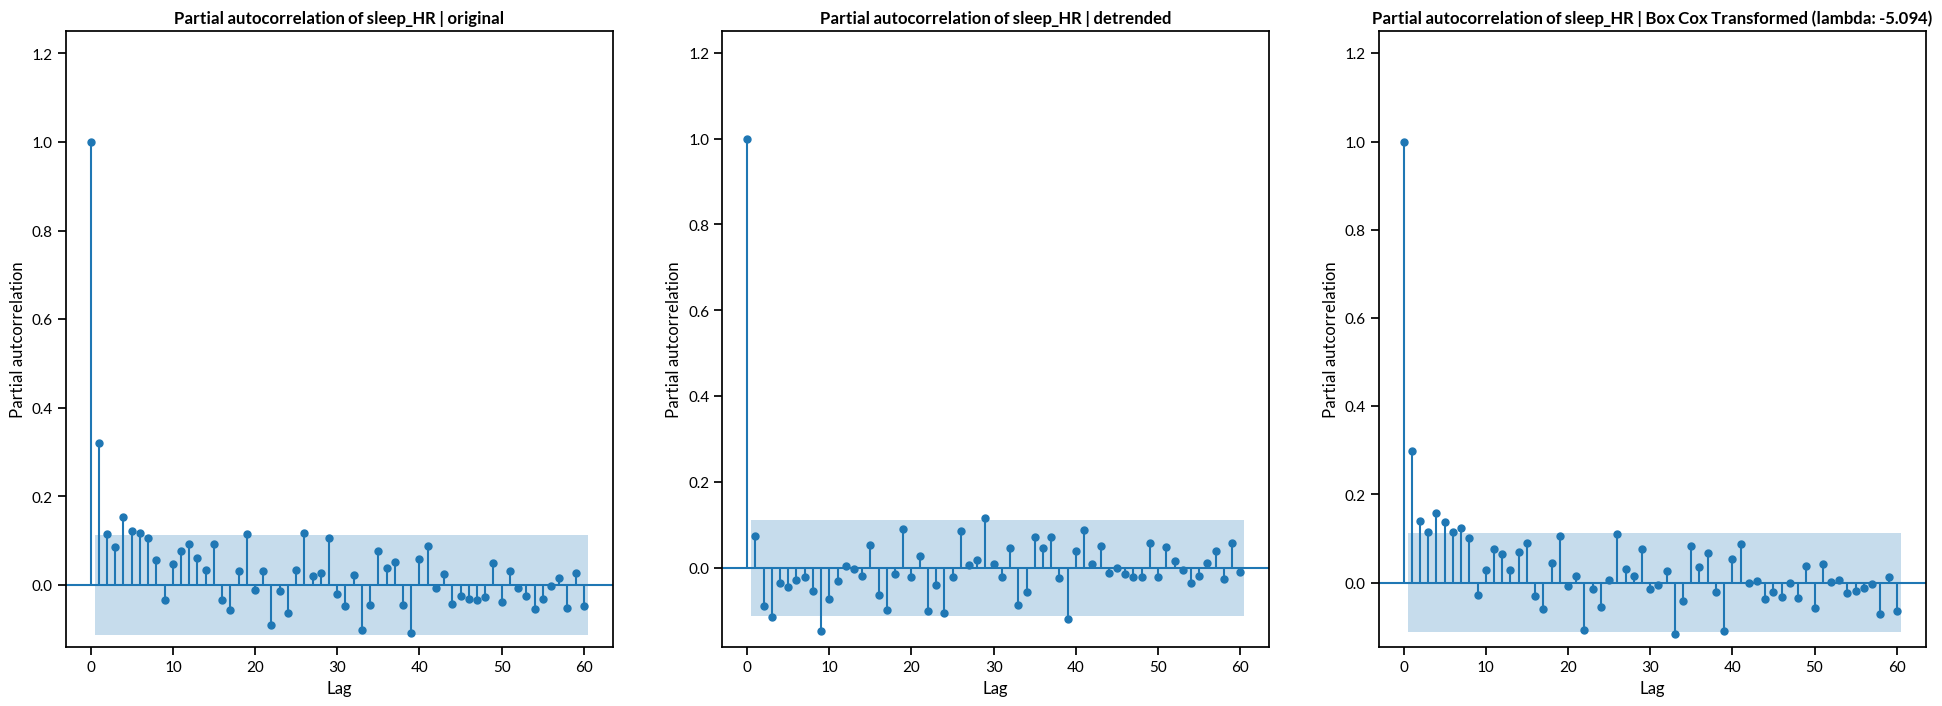

In [14]:
x = df_imputed['sleep_HR']

# Compute the trend with LOWESS
res = lowess(endog=x, exog=np.arange(len(x)), frac=.1)
x_lowess = x - res[:, 1]

# Perform Box-Cox transformation on original data
transformed_data, best_lambda = boxcox(x) 
x_box_cox = transformed_data

# Check seasonality by PACF
fig, ax = plt.subplots(ncols=3, figsize=[24, 8], sharex=True)
for i, n, x_ in zip(range(3), ['original', 'detrended', f'Box Cox Transformed (lambda: {best_lambda:.3f})'], [x, x_lowess, x_box_cox]):
    plot_pacf(
        x=x_,
        lags=60,
        ax=ax[i],
        alpha=0.05,
        auto_ylims=True
    )
    ax[i].set_title(f"Partial autocorrelation of sleep_HR | {n}")
    ax[i].set_ylabel("Partial autcorrelation")
    ax[i].set_xlabel("Lag");

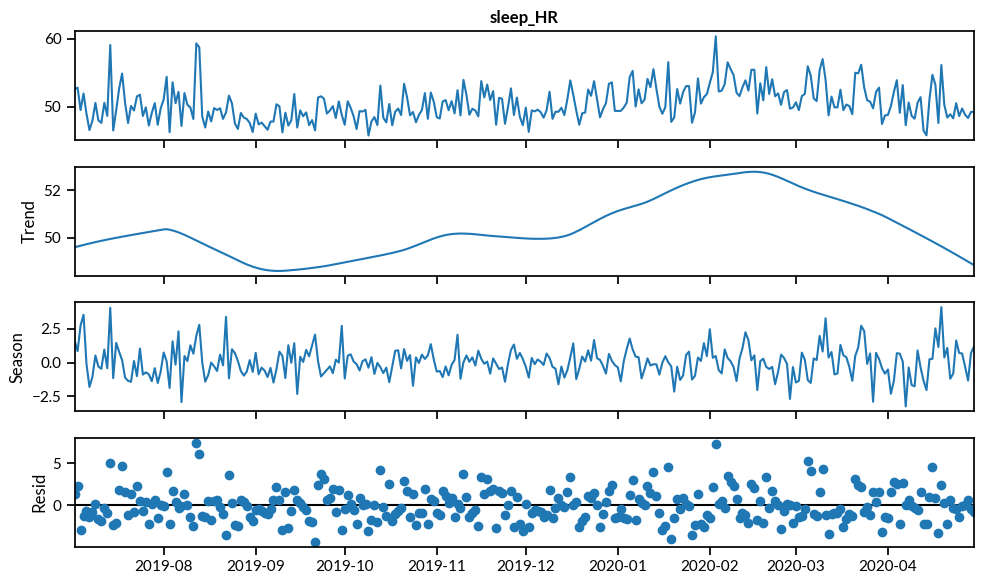

In [15]:
# Break the timeseries into trend, seasonality, and residual components
res_sleep_HR = STL(
    x,
    period=39,
    seasonal=31,).fit()

# Parameters for MSTL
# periods=[19, 26], # 2, 4, 5, 6, 
# windows=[31, 31]

# Plot the full decomposition
res_sleep_HR.plot();

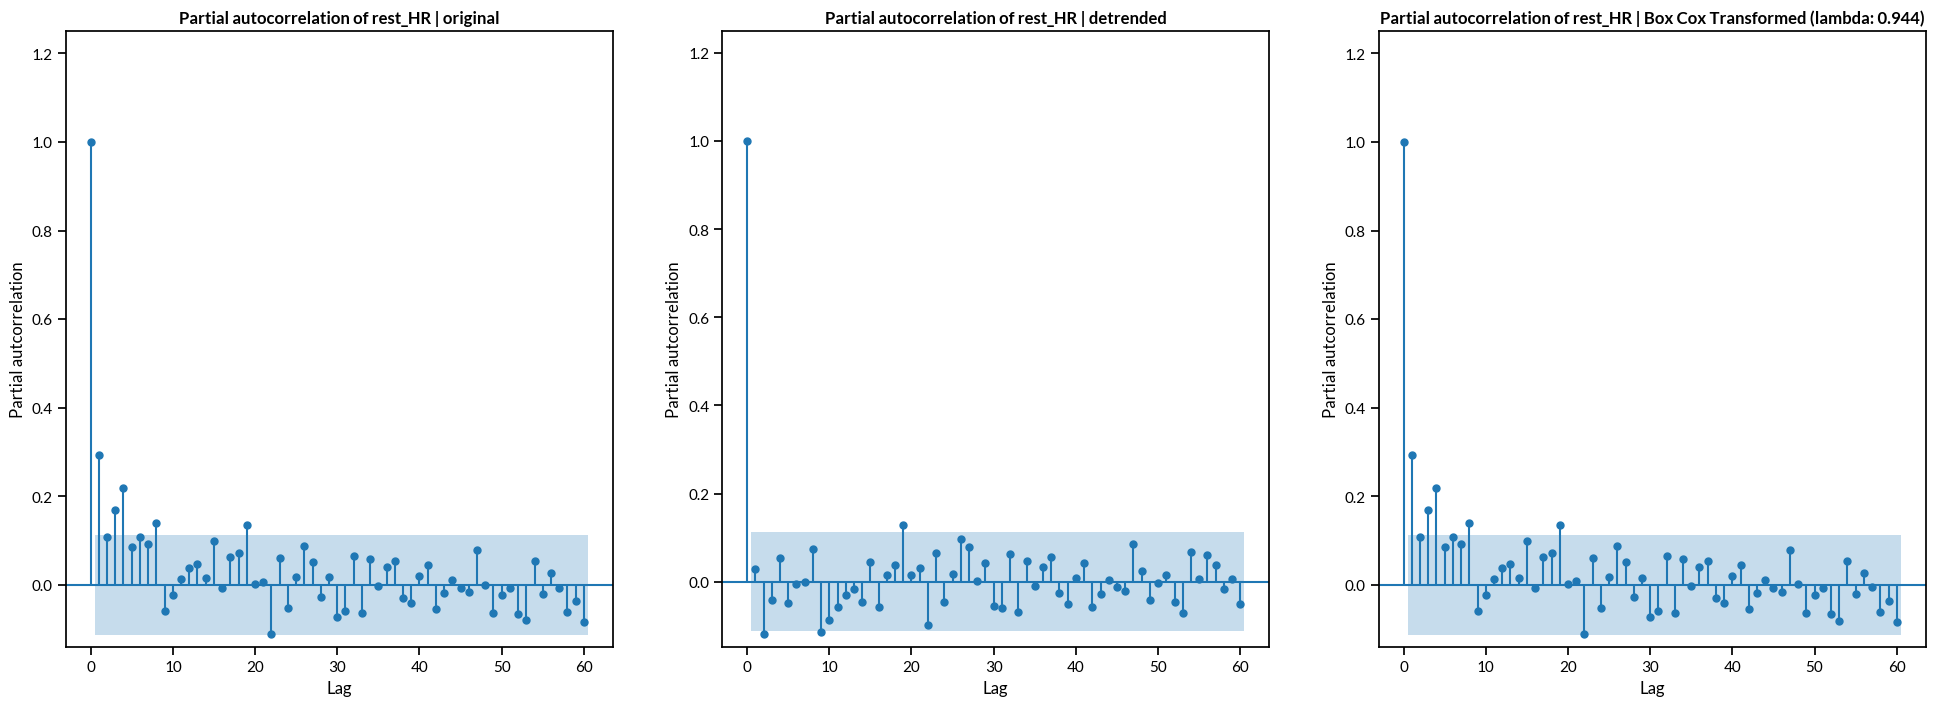

In [16]:
x = df_imputed['rest_HR']

# Compute the trend with LOWESS
res = lowess(endog=x, exog=np.arange(len(x)), frac=.1)
x_lowess = x - res[:, 1]

# Perform Box-Cox transformation on original data
transformed_data, best_lambda = boxcox(x) 
x_box_cox = transformed_data

# Check seasonality by PACF
fig, ax = plt.subplots(ncols=3, figsize=[24, 8], sharex=True)
for i, n, x_ in zip(range(3), ['original', 'detrended', f'Box Cox Transformed (lambda: {best_lambda:.3f})'], [x, x_lowess, x_box_cox]):
    plot_pacf(
        x=x_,
        lags=60,
        ax=ax[i],
        alpha=0.05,
        auto_ylims=True
    )
    ax[i].set_title(f"Partial autocorrelation of rest_HR | {n}")
    ax[i].set_ylabel("Partial autcorrelation")
    ax[i].set_xlabel("Lag");

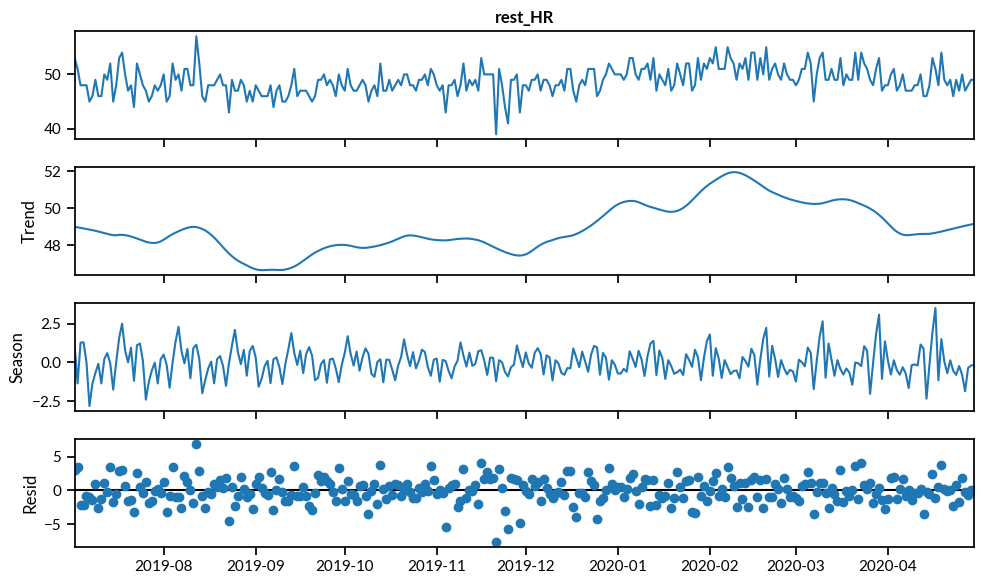

In [17]:
# Break the timeseries into trend, seasonality, and residual components
res_rest_HR = STL(
    x,
    period=19, # [3, 4, 8, 19] for MSTL
    seasonal=31).fit()

# Plot the full decomposition
res_rest_HR.plot();

### <font color = lightskyblue>3. Missing Data Imputation</font>

In this part, we revisit the missing values previously imputed with forward filling. Here, we employ a two-step strategy for a more robust imputation:

1. __Seasonal Adjustment and Linear Interpolation__: 

    We subtract the seasonal component, obtained from the time series decomposition, from the data series. This removes the influence of seasonality on the missing values. Then, we utilize linear interpolation to fill the missing values.

This approach offers a more reasonable imputation compared to simply using forward filling, as it considers the underlying seasonality of the data.

In [18]:
# Fill NA values
def fill_na(col_name, res, df_imputed):
    # Extract seasonal component (a dataframe)
    seasonal_component = res.seasonal

    # De-seasonlize original data
    df_deseasonalised = df_imputed[col_name].copy()
    if not isinstance(seasonal_component, pd.Series):
        for i in seasonal_component.columns:
            df_deseasonalised -= seasonal_component[i]
    else:
        df_deseasonalised -= seasonal_component

    # Perform linear interpolation on de-seasonalised data
    df_deseasonalised_imputed = df_deseasonalised.interpolate(method="linear")

    # Add seasonal component back to get the final imputed time series
    if not isinstance(seasonal_component, pd.Series):
        for i in seasonal_component:
            df_deseasonalised_imputed += seasonal_component[i]
    else:
        df_deseasonalised_imputed += seasonal_component

    # Plot the imputed time series
    imputed_data = df_deseasonalised_imputed.to_frame().rename(columns={0: col_name}) # Transform the series into dataframe to use plot method
    ax = imputed_data[[col_name]].plot(linestyle="-", marker=".", figsize=[16, 8], legend=None)
    # Mark the imputed points
    imputed_data[[col_name]][df_d[[col_name]].isnull()].plot(ax=ax, legend=None, marker=".", color="r", )

    ax.set_title(f"{col_name} with imputed data")
    ax.set_ylabel("Value")
    ax.set_xlabel("Date")
    
    return imputed_data[col_name]

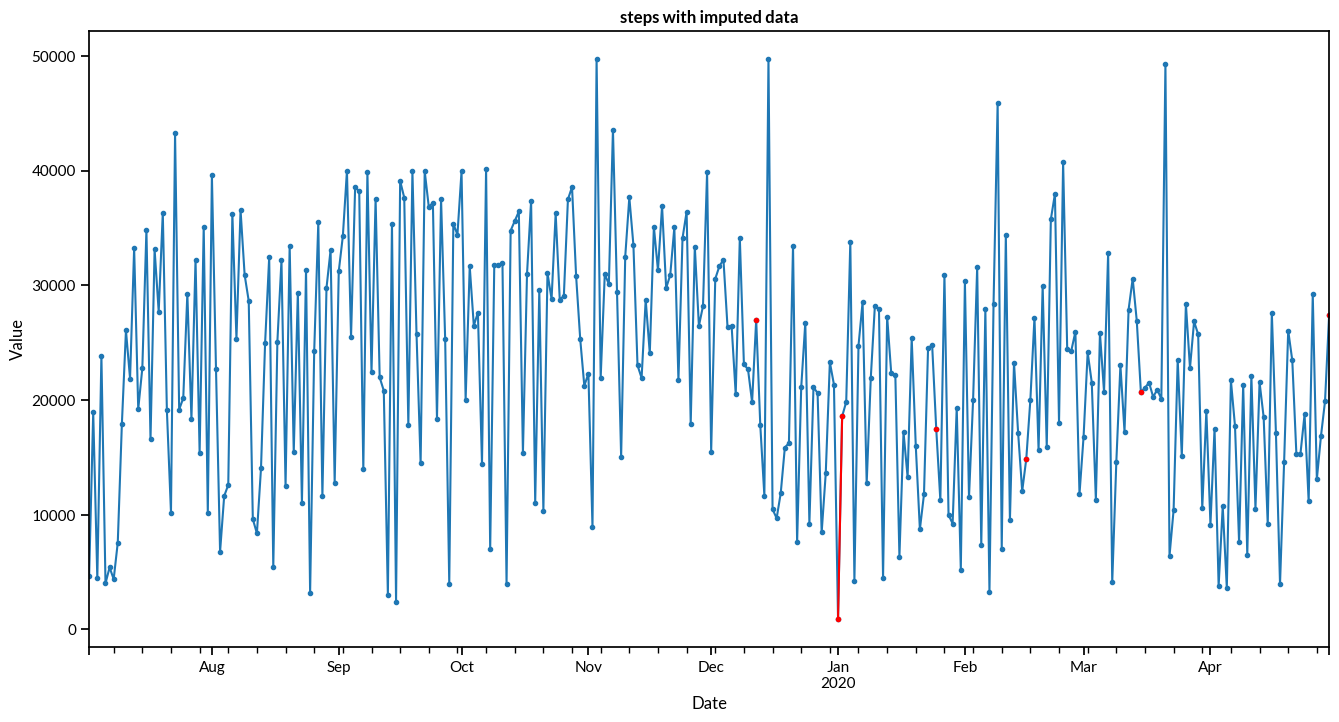

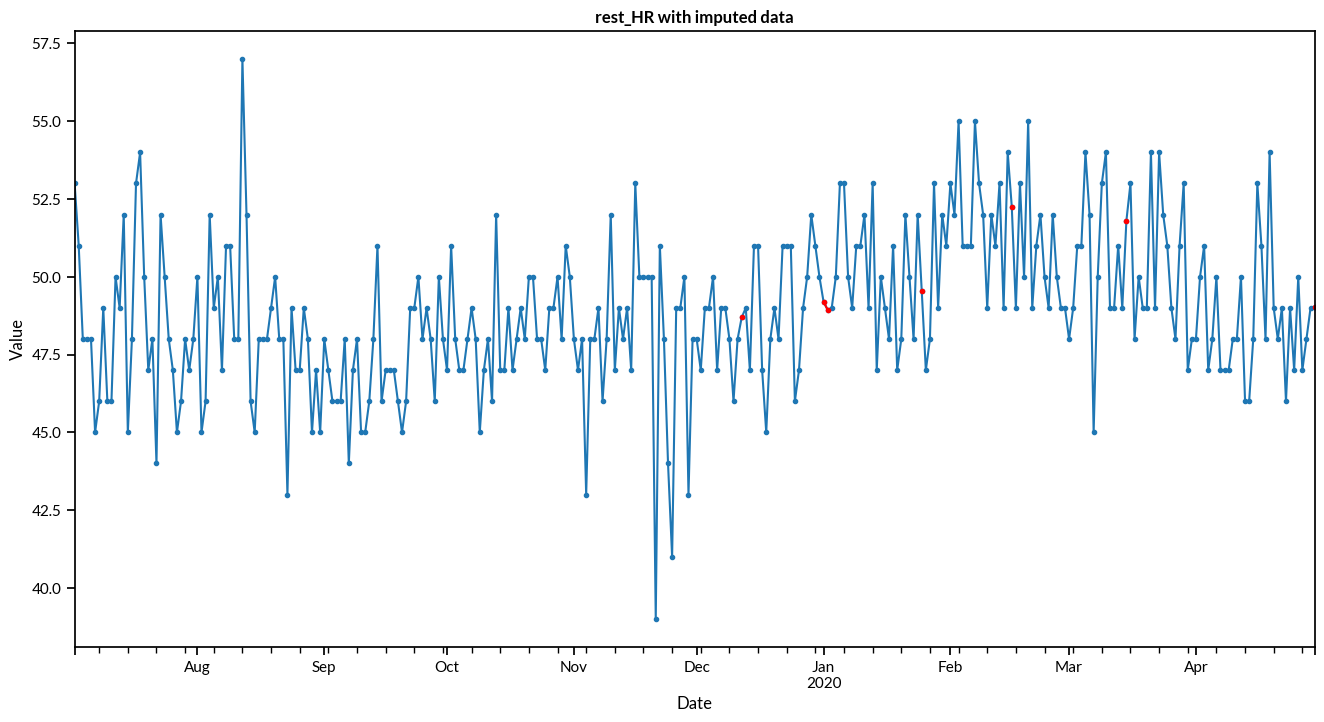

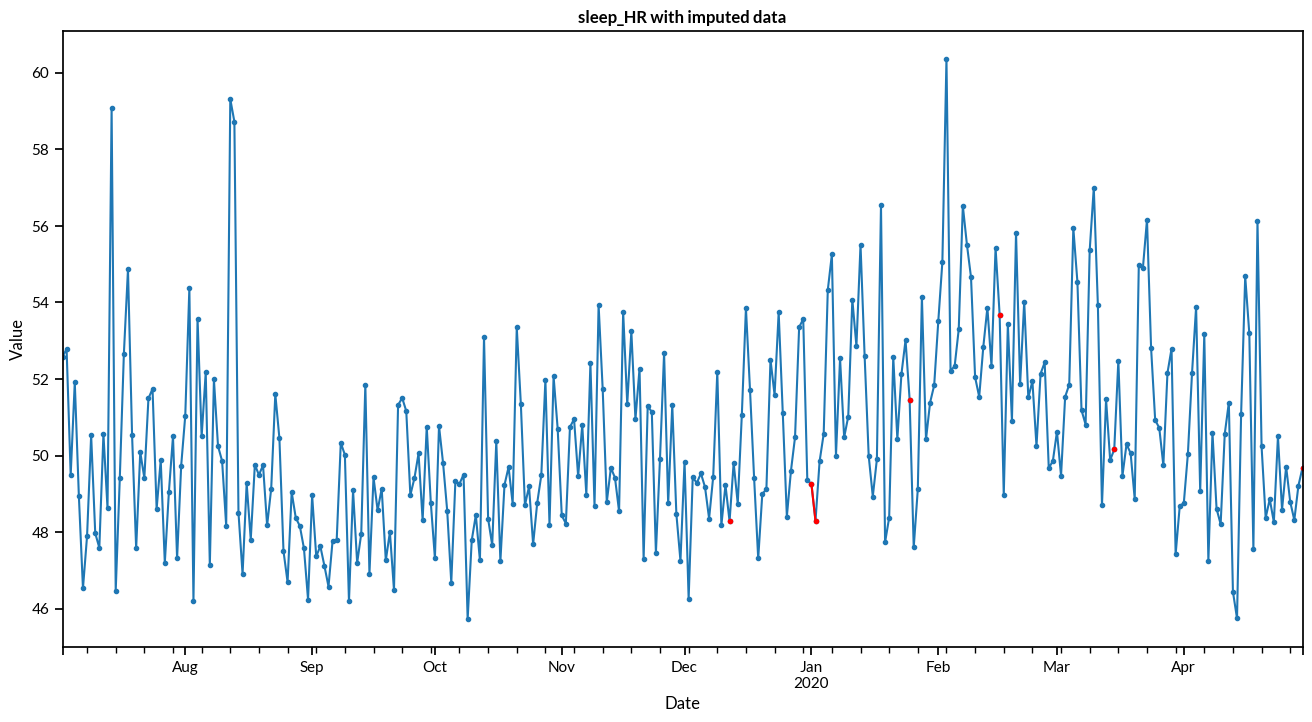

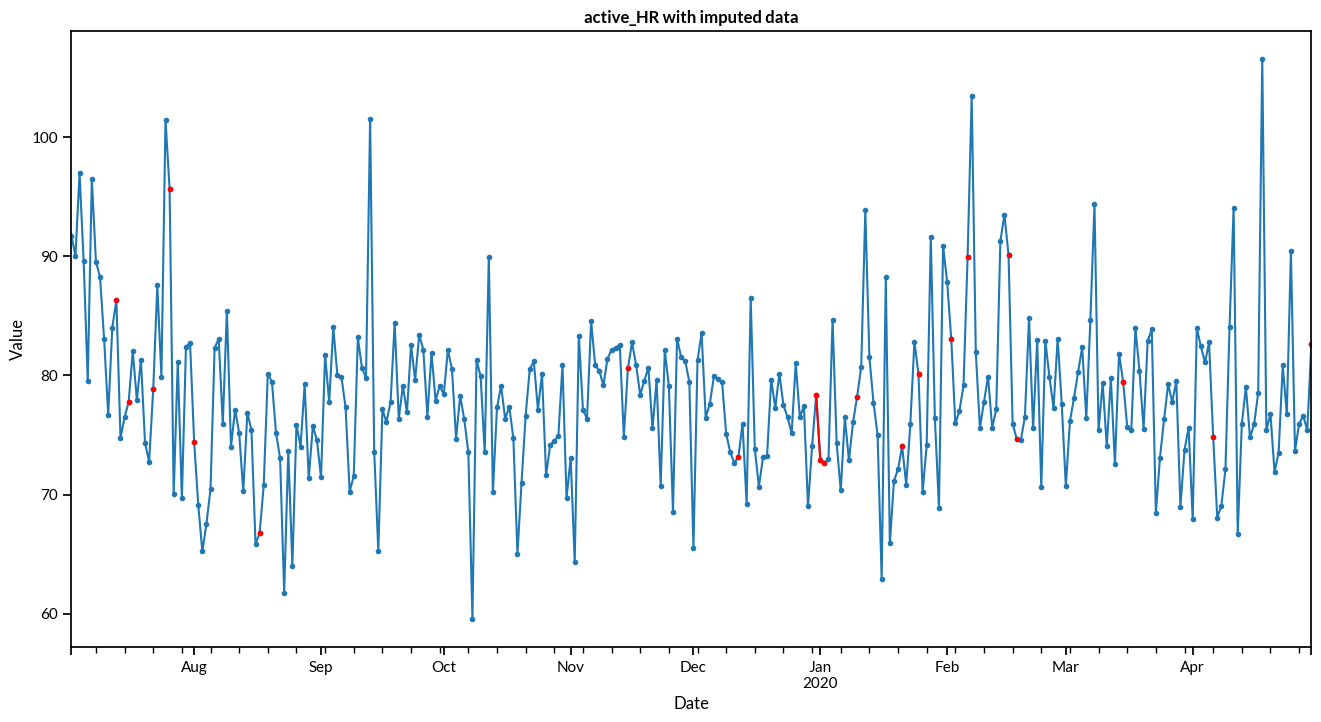

In [19]:
# Impute the missing values
for i, res in zip(['steps', 'rest_HR', 'sleep_HR', 'active_HR'], [res_step, res_rest_HR, res_sleep_HR, res_active_HR]):
    imputed_data = fill_na(i, res, df_d)
    df_imputed[i] = imputed_data

In [20]:
df_imputed.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 304 entries, 2019-07-02 to 2020-04-30
Freq: D
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   steps      304 non-null    float64
 1   rest_HR    304 non-null    float64
 2   sleep_HR   304 non-null    float64
 3   active_HR  304 non-null    float64
dtypes: float64(4)
memory usage: 11.9 KB


In [21]:
# Save the processed data
df_imputed.to_csv('./rest_hr_forecast_ready.csv',)

### <font color = lightskyblue>4. EDA</font>

In this part, we mainly examine the distribution on our data. We can see that sleeping heart rate is quite similar to our target variable, resting heart rate. On the other hand, the `steps` value is much larger than heart rate values, so normalization is needed.

In [57]:
# Add datetime related data
dtfs = DatetimeFeatures(
    variables='index',  # None: it identifies the datetime variable automatically
    features_to_extract=["week", 'weekend', 'month', "year", "day_of_week", "day_of_month"],
)
data = dtfs.fit_transform(df)
data.head()

,steps,rest_HR,sleep_HR,active_HR,week,weekend,month,year,day_of_week,day_of_month
date,,,,,,,,,,
2019-07-02,4649.0,53.0,52.581699,91.736497,27,0,7,2019,1,2
2019-07-03,18921.0,51.0,52.781553,90.043272,27,0,7,2019,2,3
2019-07-04,4450.0,48.0,49.488814,96.958359,27,0,7,2019,3,4
2019-07-05,23833.0,48.0,51.916493,89.613564,27,0,7,2019,4,5
2019-07-06,4015.0,48.0,48.940379,79.569532,27,1,7,2019,5,6


In [28]:
data[fs+[target_]].describe().loc[['min', 'max', 'mean', 'std']].round(2).T

,min,max,mean,std
steps,910.05,49732.00,22700.85,10589.83
sleep_HR,45.73,60.35,50.43,2.57
active_HR,59.54,106.56,78.08,6.79
rest_HR,39.00,57.00,48.90,2.48


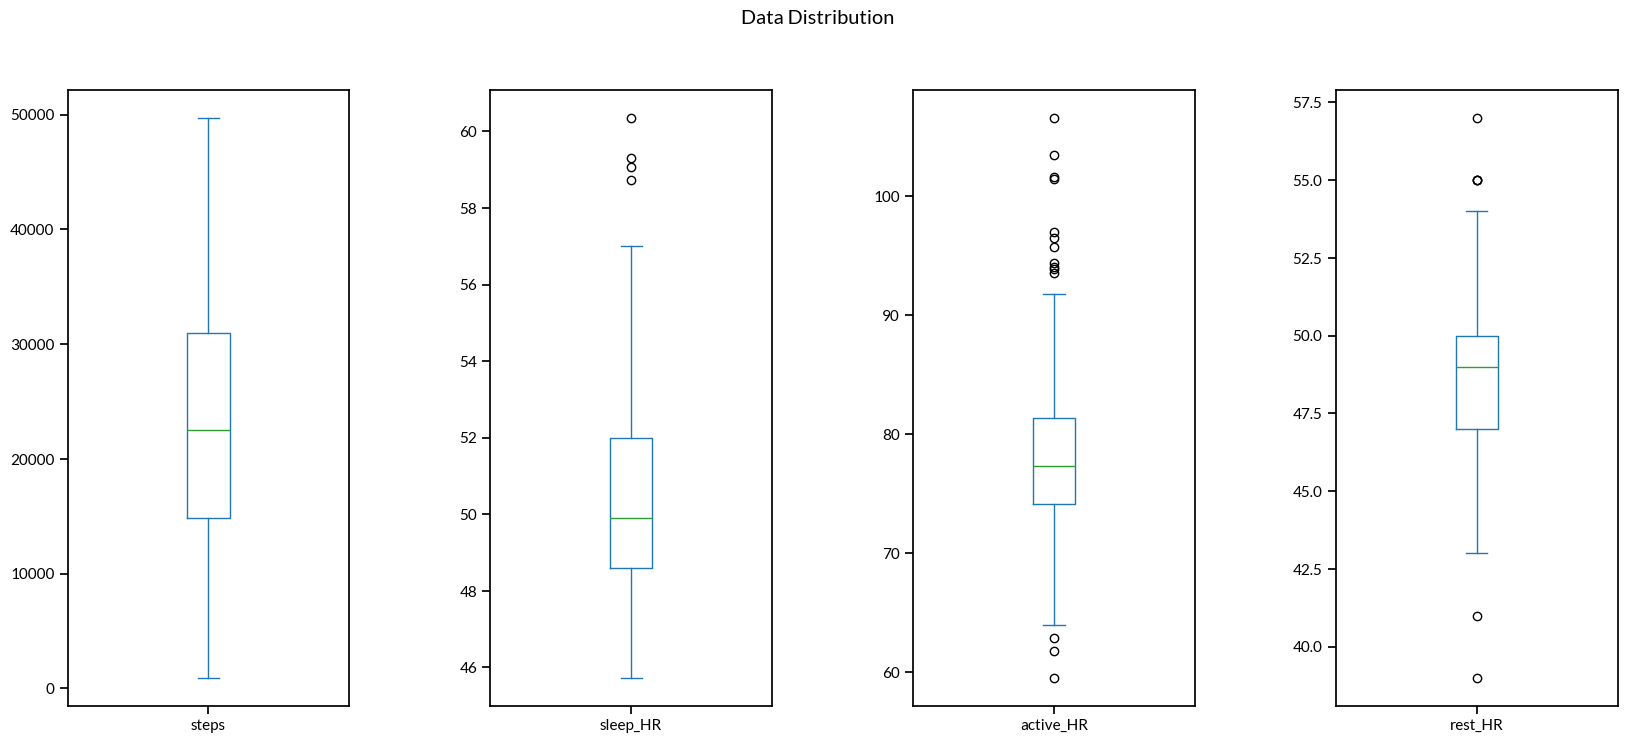

In [32]:
# Data Distribution
data[fs+[target_]].plot(
    kind='box',
    subplots=True,
    sharey=False,
    title='Data Distribution',
    figsize=(20, 8),
)
plt.subplots_adjust(wspace=0.5);

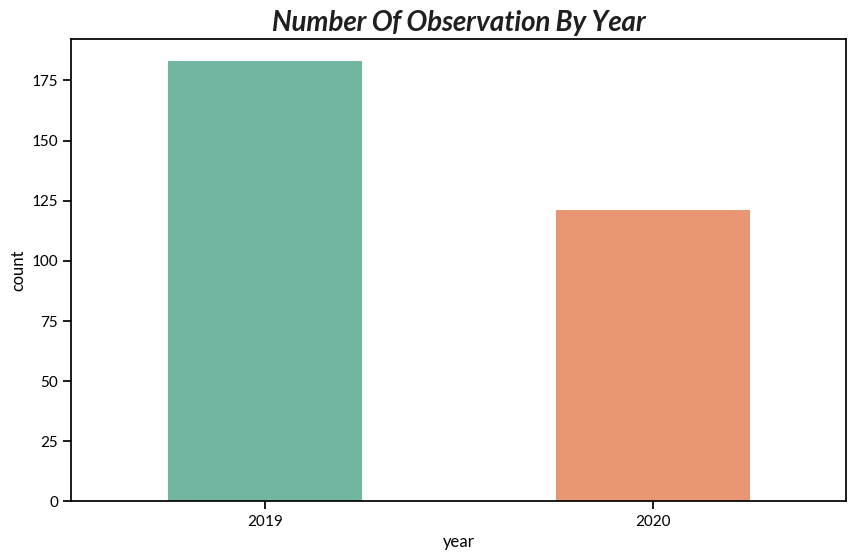

In [58]:
# Observation amount by year
ax = sns.countplot(x='year', data = data, palette = 'Set2', width=.5)
ax.set_title('Number Of Observation By Year', fontsize=20, fontdict=font_t)
plt.show()

In [61]:
# Aggregate the data
a = data.groupby([pd.Grouper(freq='MS'),])['month'].value_counts().reset_index()
a['year'] = a['date'].dt.year
a['year'] = a['year'].astype('category')

# Observation distribution by month in each year
t_ = ['Number Of Observation By Month', '201907 ~ 202004']
fig = px.bar(a, x='date', y='count', color='year', title=format_title(*t_), template=custom_template, text='count')
fig.update_xaxes(showspikes=True, spikecolor="green", spikesnap="cursor", spikemode="across")
fig.update_yaxes(showspikes=True, spikecolor="orange", spikethickness=2)
fig.show()

In [62]:
# Target distribution by month in each year
t_ = ['Monthly Resting HR Distribution', '201907 ~ 202004']
fig = px.box(data, x='year', y='rest_HR', color='month', title=format_title(*t_), template=custom_template,
category_orders={"month": [str(i) for i in range(1, 13)]})
fig.update_traces(boxmean=True)
fig.update_xaxes(showspikes=True, spikecolor="green", spikesnap="cursor", spikemode="across")
fig.update_yaxes(showspikes=True, spikecolor="orange", spikethickness=2)
fig.show()

In [71]:
# Target distribution by month in each year
t_ = ['Monthly Sleeping HR Distribution', '201907 ~ 202004']
fig = px.box(data, x='year', y='sleep_HR', color='month', title=format_title(*t_), template=custom_template,
category_orders={"month": [str(i) for i in range(1, 13)]})
fig.update_traces(boxmean=True)
fig.update_xaxes(showspikes=True, spikecolor="green", spikesnap="cursor", spikemode="across")
fig.update_yaxes(showspikes=True, spikecolor="orange", spikethickness=2)
fig.show()

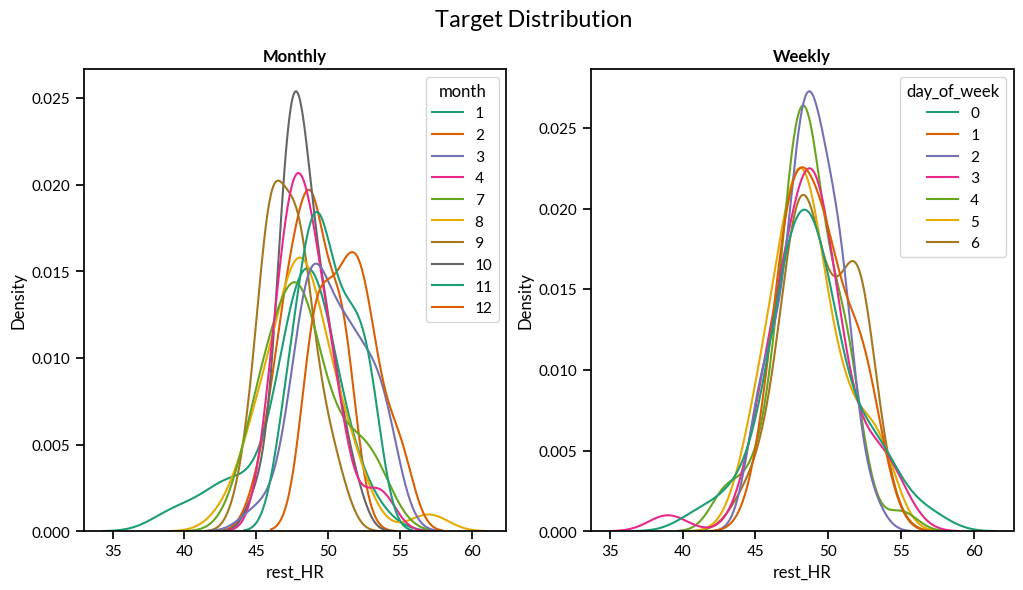

In [70]:
fig, ax = plt.subplots(ncols=2, figsize=(12, 6), )
sns.kdeplot(data, x="rest_HR", hue="month", ax=ax[0], palette='Dark2')
sns.kdeplot(data, x="rest_HR", hue="day_of_week", ax=ax[1], palette='Dark2')

fig.suptitle('Target Distribution')
ax[0].set_title("Monthly")
ax[1].set_title("Weekly");

In [200]:
# Steps distribution by month in each year
t_ = ['Steps Distribution', '201907 ~ 202004']
fig = px.box(df_imputed, x='year', y='steps', color='month', title=format_title(*t_), template=custom_template,
category_orders={"month": [str(i) for i in range(1, 13)]})
fig.update_traces(boxmean=True)
fig.update_xaxes(showspikes=True, spikecolor="green", spikesnap="cursor", spikemode="across")
fig.update_yaxes(showspikes=True, spikecolor="orange", spikethickness=2)
fig.show()

## <font color = deepskyblue>III. Modeling</font>

In this section, there are two main tasks, feature engineering and modeling.

1. __Feature engineering__

    We will utilize the `sktime` library to extract time-based features like seasonality and trends. Tools like `DateTimeFeatures` and `TimeSince` are helpful for this purpose. Additionally, `FourierFeatures` can be used as explanatory variables for complex seasonal patterns, but refer to the [<u>official doc</u>](https://www.sktime.net/en/stable/api_reference/auto_generated/sktime.transformations.series.fourier.FourierFeatures.html) for more information. Considering the 19-period seasonality identified in section two, we will also include lag features and rolling means using `WindowSummarizer`.

2. __Modeling__

    To compare the performance of deep learning methods with simpler approaches, we will explore three linear regression models from `sklearn`: `LinearRegression`, `Ridge`, and `Lasso`. For deep learning, we will experiment with `DNN`, `1D CNN with LSTM cell`, and `LSTM` models.

Training Strategy and Findings

1. __Data split__

    Due to the limited amount of data, we will split the data only into training and test sets. However, for future work, incorporating a validation set for hyperparameter tuning would be beneficial.

2. __Evaluation Metrics__

    We selected __Root Mean Squared Error (RMSE)__ as the metric for comparing the performance of linear regression models. For deep learning models, we will use __Mean Absolute Error (MAE)__. The choice of MAE for deep learning models can be further explained based on the specific properties of the metric (e.g., less sensitive to outliers).

3. __Forecasting Strategy__

    I use <u>__recursive forecasting__</u> to forecast one single output a time.

4. __Findings__

    Deep learning methods demonstrate strong capabilities. Interestingly, when including Fourier features in the training data, all deep learning models failed to converge, resulting in poor forecasting performance. We believe this might be due to Fourier features capturing high-frequency noise that the models struggle with or that doesn't significantly contribute to predicting resting heart rate. These features might be misleading the models.

    On the other hand, excluding Fourier features but including others limited the models' ability to capture whole patterns beyond trend and seasonality, leading to poor generalization. Consequently, we opted to skip feature engineering for deep learning models in this instance, and the prediction results improved significantly. This finding highlights the importance of understanding the data and the model's capabilities when choosing feature engineering strategies.

In [4]:
# Fourier features
from sktime.transformations.series.fourier import FourierFeatures
# Date time features to capture seasonality
from sktime.transformations.series.date import DateTimeFeatures
# Require OneHotEncoder to create seasonal dummy variables
from sklearn.preprocessing import OneHotEncoder
# Lag and window features
from sktime.transformations.series.summarize import WindowSummarizer
# Time features for trend 
from sktime.transformations.series.time_since import TimeSince
# Linear regression model
from sklearn import linear_model
from sklearn.preprocessing import PolynomialFeatures
# Rescaling transformer for linear models with regularisation
from sklearn.preprocessing import MinMaxScaler
# Pipelines to create feature engineering pipeline
from sklearn.pipeline import make_pipeline, make_union
# Used to reset sklearn estimators
from sklearn.base import clone
from sklearn.metrics import root_mean_squared_error

# Ensure all sklearn transformers output pandas dataframes
from sklearn import set_config
set_config(transform_output="pandas")  # Upgrade to scikit-learn 0.12 for this feature

# Tensorflow for deep learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

performance = {}

In [5]:
# Load processed data
df = pd.read_csv(
     "./rest_hr_forecast_ready.csv", 
     parse_dates=['date'], 
     )
df.set_index('date', inplace=True)
target_ = 'rest_HR'
fs = ['steps', 'sleep_HR', 'active_HR']
df.head()

,steps,rest_HR,sleep_HR,active_HR
date,,,,
2019-07-02,4649.0,53.0,52.581699,91.736497
2019-07-03,18921.0,51.0,52.781553,90.043272
2019-07-04,4450.0,48.0,49.488814,96.958359
2019-07-05,23833.0,48.0,51.916493,89.613564
2019-07-06,4015.0,48.0,48.940379,79.569532


In [6]:
# Check if GPU is used
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### <font color = lightskyblue>1. Data Preparation</font>

In [47]:
# Polynomial time features for trend
time_feats = make_pipeline(
    TimeSince(), 
    PolynomialFeatures(degree=1, include_bias=False)
)

# Datetime features
# Specify which datetime features to create
datetime_features = [
    "is_weekend",
    'month_of_year',
    'day_of_week',
]
datetime_feats = make_pipeline(
    DateTimeFeatures(
        manual_selection=datetime_features,
        keep_original_columns=False,
    ),
    OneHotEncoder(
        sparse_output=False, # Required to enable pandas output.
        handle_unknown='ignore',
        drop="first"
    )
)

# Create the fourier features [daily, weekly]
fourier_feats = FourierFeatures(
    sp_list=[19],
    fourier_terms_list=[3],
    freq="D",
    keep_original_columns=False,
)


# Features computed from the target.
# Compute lag and window features.
lag_window_feats = WindowSummarizer(
    lag_feature={
        "lag": [1, 19], # np.arange(1, 25),  # Lag features.
        "mean": [[1, 2], [1, 19]],  # [[lag, window size]]
    },
    target_cols=[target_],
    truncate="bfill",  # Backfill missing values from lagging and windowing.
)

In [57]:
pipeline = make_union(
    time_feats,
    # fourier_feats,      # Can be excluded when experimenting without Fourier & lag features
    # lag_window_feats,   # Can be excluded when experimenting without Fourier & lag features
    datetime_feats,
)

# Apply min-max scaling to all the features
pipeline = make_pipeline(pipeline, MinMaxScaler())
pipeline

Pipeline(steps=[('featureunion',
                 FeatureUnion(transformer_list=[('pipeline-1',
                                                 Pipeline(steps=[('timesince',
                                                                  TimeSince()),
                                                                 ('polynomialfeatures',
                                                                  PolynomialFeatures(degree=1,
                                                                                     include_bias=False))])),
                                                ('pipeline-2',
                                                 Pipeline(steps=[('datetimefeatures',
                                                                  DateTimeFeatures(manual_selection=['is_weekend', 'month_of_year',
                                   'day_of_week'])),
                                                                 ('onehotencoder',
                                                                  OneHotEncoder(drop='first',
                                                                                handle_unknown='ignore',
                                                                                sparse_output=False))]))])),
                ('minmaxscaler', MinMaxScaler())])

In [111]:
# We can use `clone` to return an unfitted version of the pipeline.
pipeline = clone(pipeline)

In [7]:
# --- CREATE TRAINING, VALIDATION & TESTING DATAFRAME  --- #
n = len(df)
train_data = df[0:int(n*0.75)]
test_data = df[int(n*0.75):]

print("Before feature engineering:")
print(f"Training data shape: {train_data.shape}")
print(f"Test data shape: {test_data.shape}")

Before feature engineering:
Training data shape: (228, 4)
Test data shape: (76, 4)


In [141]:
# Feature engineering
df_train = pipeline.fit_transform(train_data)
y_train = train_data[target_]

df_test = pipeline.transform(test_data)
y_test = test_data[target_]

# Rename the column
df_train.rename({'time_since_2019-07-02 00:00:00' : 'trend'}, axis=1, inplace=True)
df_test.rename({'time_since_2019-07-02 00:00:00' : 'trend'}, axis=1, inplace=True)

print("After feature engineering:")
print(f"Training data shape: {df_train.shape}")
print(f"Test data shape: {df_test.shape}")

After feature engineering:
Training data shape: (228, 15)
Test data shape: (76, 15)


In [8]:
# Without any feature engineering
scaler = MinMaxScaler()

X_train = scaler.fit_transform(train_data[fs]).values.reshape((train_data.shape[0], 1, len(fs)))
y_train = train_data[target_]

X_test = scaler.transform(test_data[fs]).values.reshape((test_data.shape[0], 1, len(fs)))
y_test = test_data[target_]

num_train_samples = X_train.shape[0]
num_test_samples = X_test.shape[0]

print("Data preparation for modeling:")
print(f"Training data\n X: {X_train.shape} | y: {y_train.shape}")
print(f"Testing data\n X: {X_test.shape} | y: {y_test.shape}")

Data preparation for modeling:
Training data
 X: (228, 1, 3) | y: (228,)
Testing data
 X: (76, 1, 3) | y: (76,)


In [142]:
# With feature engineering

X_train = df_train.values.reshape((df_train.shape[0], 1, df_train.shape[1]))
X_test = df_test.values.reshape((df_test.shape[0], 1, df_test.shape[1]))

num_train_samples = X_train.shape[0]
num_test_samples = X_test.shape[0]

print("Data preparation for modeling:")
print(f"Training data\n X: {X_train.shape} | y: {y_train.shape}")
print(f"Testing data\n X: {X_test.shape} | y: {y_test.shape}")

Data preparation for modeling:
Training data
 X: (228, 1, 15) | y: (228,)
Testing data
 X: (76, 1, 15) | y: (76,)


In [9]:
# Config for recursive training

# Define time of first forecast, determined by our train / val / test split
forecast_start_time = pd.to_datetime("2020-02-15")

# Define number of steps to forecast.
num_of_forecast_steps = num_test_samples

# Create a list of periods that we'll forecast over.
forecast_horizon = pd.date_range(
    forecast_start_time, periods=num_of_forecast_steps, freq="D"
)

# How much data in the past is needed to create our features
look_back_window_size = pd.DateOffset(days=19) # We need the latest 19 time periods
                                               # in our predict dataframe to build our
                                               # window features.

### <font color = lightskyblue>2. Linear Regression</font> 

In [100]:
# Define three different linear model
model_linear = linear_model.LinearRegression()

model_ridge = linear_model.Ridge(alpha=.5)

model_lasso = linear_model.Lasso(alpha=.05)

In [101]:
# Model training -  Train one-step ahead forecast model
model_linear.fit(df_train.values, y_train)
model_ridge.fit(df_train.values, y_train)
model_lasso.fit(df_train.values, y_train)

Lasso(alpha=0.05)

In [102]:
# --- CREATE DYNAMIC PREDICTION DATAFRAME  --- #
# We will recursively append our forecasts to this
# dataframe and re-compute our lag and window features from the
# target in this dataframe. It contains data in both the training period
# and forecast period which is needed for some transformers (e.g., lags and windows).
look_back_start_time = forecast_start_time - look_back_window_size

# Create `df_predict` which has data going as far back
# as needed to create features which need past values.
df_predict = train_data.loc[look_back_start_time:].copy()

# Extend index into forecast horizon
df_predict = pd.concat([df_predict, pd.DataFrame(index=forecast_horizon)])

df_predict[fs] = df_predict[fs].fillna(test_data)

LinearRegression | RMSE: 1.494
Ridge | RMSE: 1.522
Lasso | RMSE: 1.429


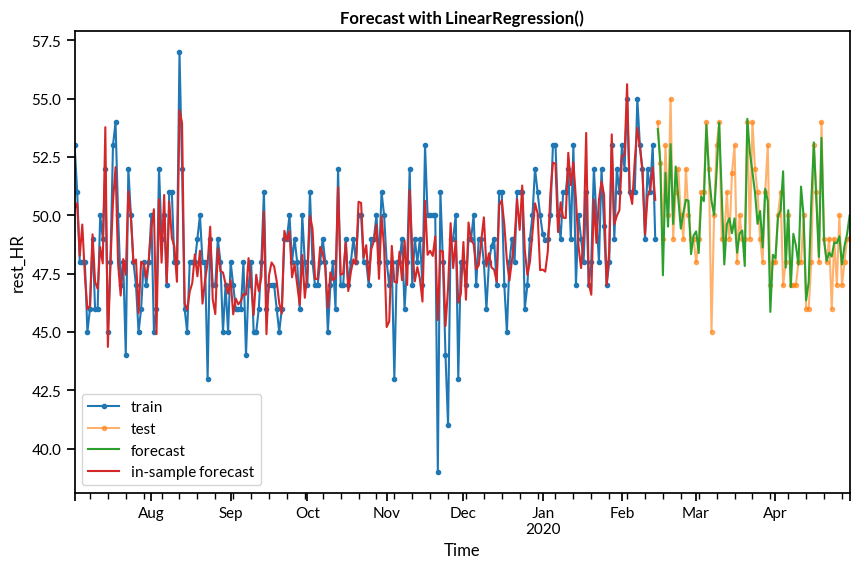

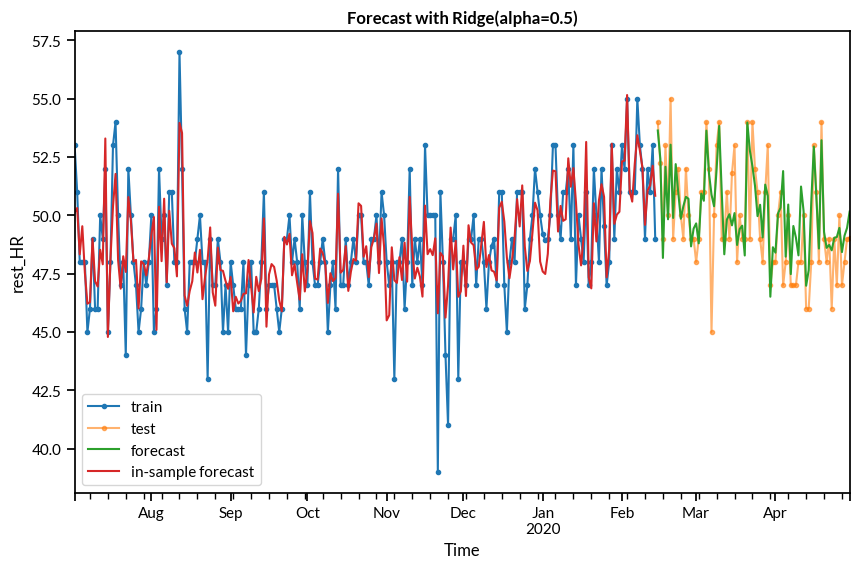

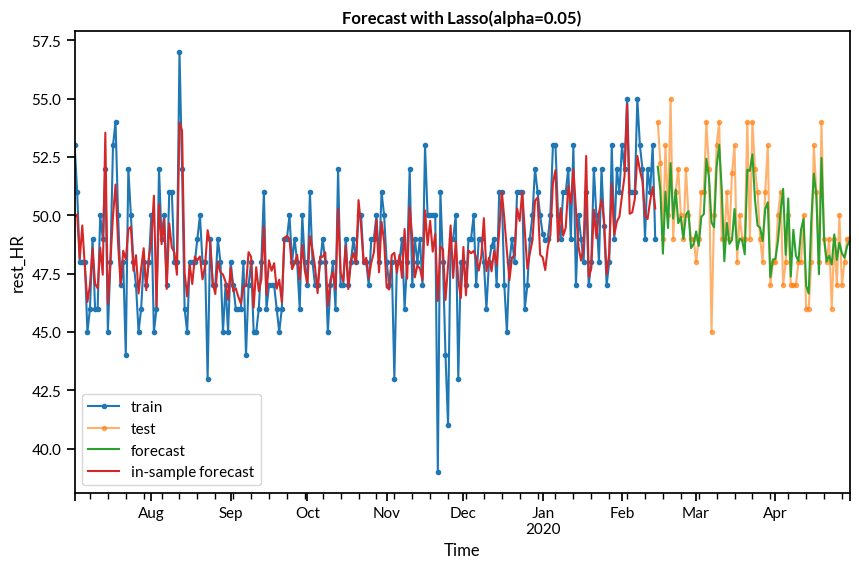

In [103]:
# --- RECURSIVE FORECASTING LOOP --- #
for n_, model_ in zip(['LinearRegression', 'Ridge', 'Lasso'], [model_linear, model_ridge, model_lasso]):

    for forecast_time in forecast_horizon:
        # Compute features during the forecast horizon
        X_test_recur = pipeline.transform(df_predict[:forecast_time])
        # print(df_predict[:forecast_time])
        X_test_ = X_test_recur.loc[[forecast_time]]

        # Predict one step ahead.
        y_pred = model_.predict(X_test_)

        # Append forecast to the target variable columnn in our
        # dynamic forecast dataframe `df_predict`. This `df_predict`
        # is ready for the next iteration where we will re-compute
        # features derived from the target such as lags and windows.
        df_predict.loc[[forecast_time], target_] = y_pred

    # --- GET FORECAST AND TEST VALUES --- #
    y_forecast = df_predict.loc[forecast_horizon, target_]

    # --- CREATE IN-SAMPLE PREDICTIONS--- #
    y_forecast_train = model_.predict(df_train.values)
    y_forecast_train = pd.DataFrame(y_forecast_train, index=train_data.index, columns=[target_])
    plot_res(y_train, y_test, y_forecast, y_forecast_train, model_)

    # Compute error metrics
    rmse = root_mean_squared_error(y_test.loc[y_forecast.index], y_forecast,)
    print(f"{n_} | RMSE: {rmse:.3f}")
    performance[n_] = rmse

    # Reset df_predict
    df_predict = train_data.loc[look_back_start_time:].copy()

    # Extend index into forecast horizon
    df_predict = pd.concat([df_predict, pd.DataFrame(index=forecast_horizon)])

    df_predict[fs] = df_predict[fs].fillna(test_data)

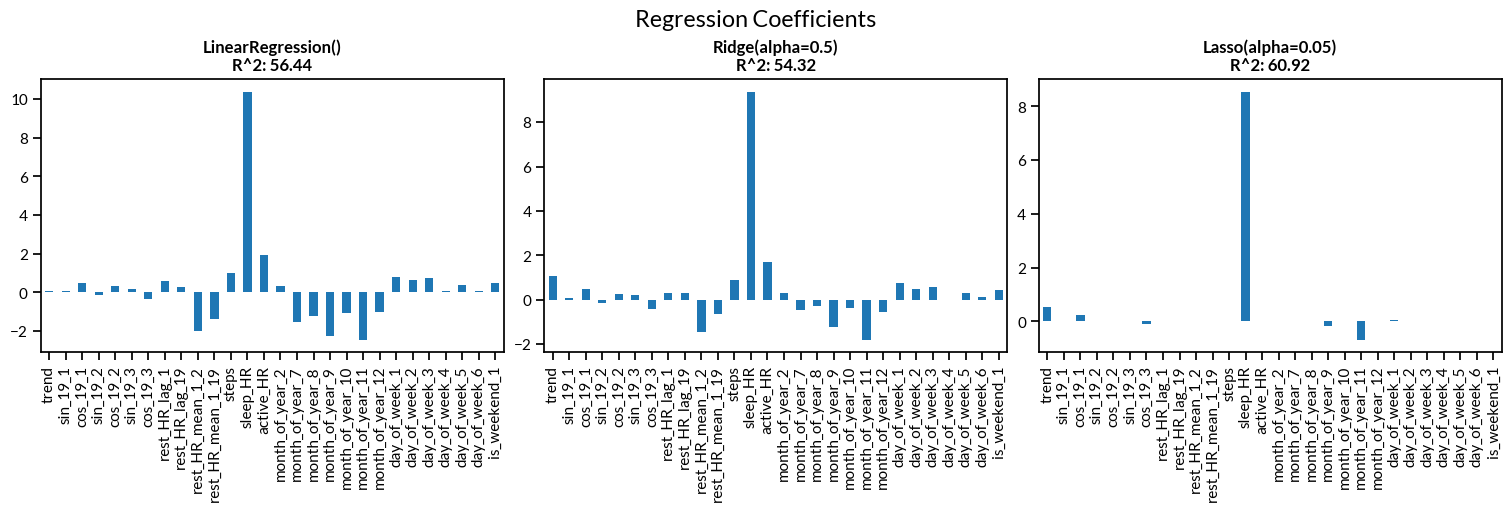

In [109]:
# Plot regression coefficients
fig, ax = plt.subplots(ncols=3, figsize=(15, 5), constrained_layout=True)

for i, model_ in zip(range(3), [model_linear, model_ridge, model_lasso]):
    pd.Series(index=df_train.columns, data=model_.coef_).plot(ax=ax[i], kind='bar', title=f'{model_}\nR^2: {model_.score(df_test.values, y_test)*100:.2f}', rot=90)
fig.suptitle('Regression Coefficients');

### <font color = lightskyblue>3. Deep Learning Models</font>

To illustrate the earlier point about our findings, we will train the DNN model on three different datasets. For simplicity, we'll focus on the DNN model here. If you're interested in exploring the performance of the rest deep learning models (LSTM, 1D CNN with LSTM), you can try training them with these same datasets and see if they exhibit similar behavior.

1. Training set with all features (with feature engineering)

2. Training set with feature engineering, but excluding Fourier features and lag/rolling mean features

3. Training set only with normalization applied (no feature engineering)

#### (1) DNN

In [152]:
# Create a simple dense connected model
inputs = keras.Input(shape=(X_train.shape[1], X_train.shape[2]))
x = keras.layers.Dense(8, activation='relu')(inputs)
x = keras.layers.Dense(4, activation='relu')(x)
outputs = keras.layers.Dense(1)(x)
model_dnn = keras.Model(inputs, outputs, name='DNN')

model_dnn.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae']
)

history = model_dnn.fit(
    X_train,
    y_train,
    epochs=50,
    batch_size=4,
    # callbacks=callback
)

Epoch 1/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 2351.9600 - mae: 48.4307
Epoch 2/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2311.2502 - mae: 48.0115
Epoch 3/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2256.3726 - mae: 47.4351
Epoch 4/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2135.7781 - mae: 46.1506
Epoch 5/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2003.6664 - mae: 44.6967
Epoch 6/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1776.5669 - mae: 42.0779
Epoch 7/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1498.4359 - mae: 38.6323
Epoch 8/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1190.8517 - mae: 34.3924
Epoch 9/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 890.0955 - mae: 29.6832
Epoch 10/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 608.9809 - mae: 24.4127
Epoch 11/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 363.6786 - mae: 18.6097
Epoch 12/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 208.1176 - mae: 13.5995
Epo

Lowest loss: 49


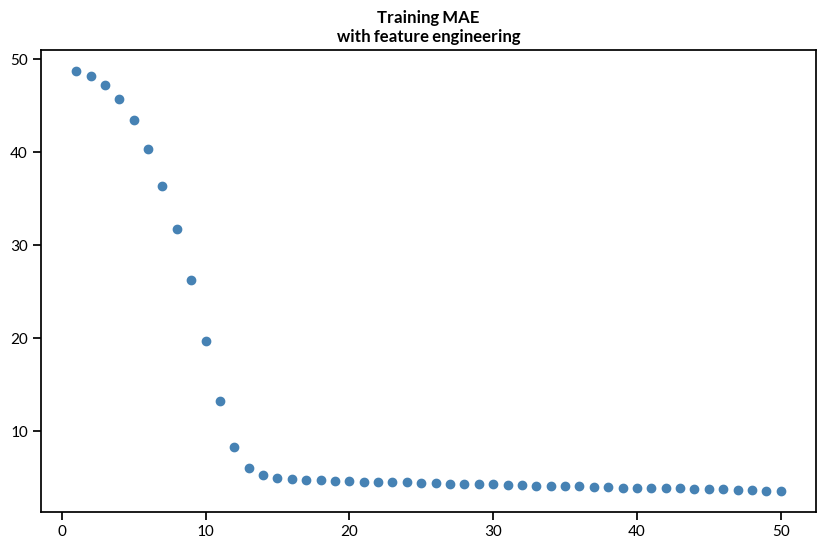

In [117]:
# Plot the result
loss = history.history['mae']
epochs = range(1, len(loss)+1)
plt.figure()
plt.scatter(epochs, loss, marker='o', c=mycolors['blue'], ) # label='Training MAE')
print(f"Lowest loss: {np.argmin(loss)}")
plt.title("Training MAE\nwith feature engineering");
# plt.legend();

Lowest loss: 48


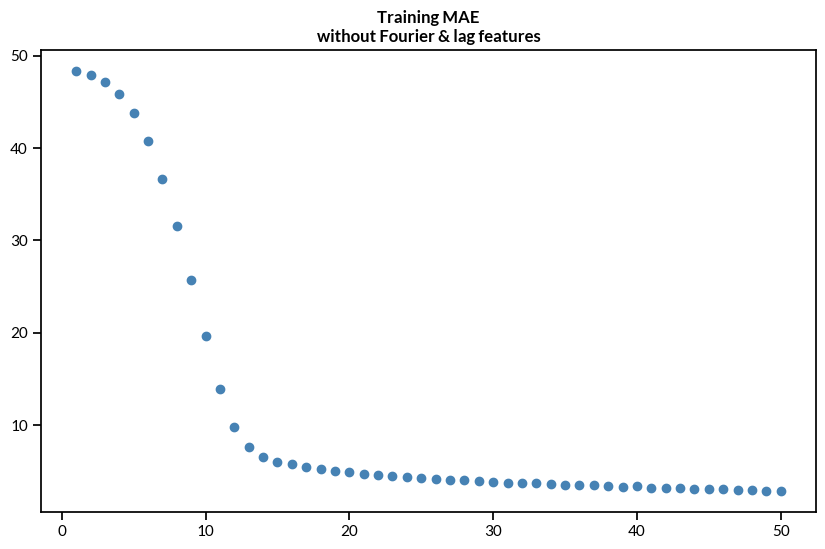

In [144]:
# Plot the result
loss = history.history['mae']
epochs = range(1, len(loss)+1)
plt.figure()
plt.scatter(epochs, loss, marker='o', c=mycolors['blue'], ) # label='Training MAE')
print(f"Lowest loss: {np.argmin(loss)}")
plt.title("Training MAE\nwithout Fourier & lag features");
# plt.legend();

Lowest loss: 49


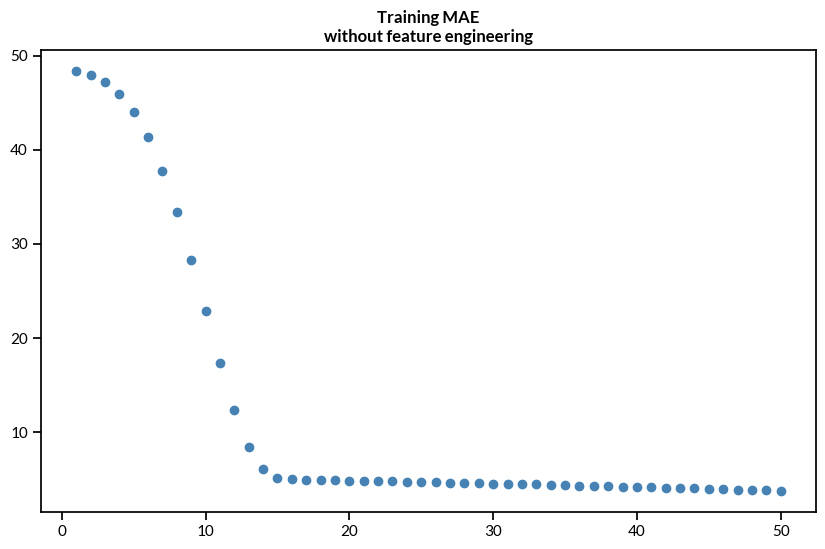

In [153]:
# Plot the result
loss = history.history['mae']
epochs = range(1, len(loss)+1)
plt.figure()
plt.scatter(epochs, loss, marker='o', c=mycolors['blue'], ) # label='Training MAE')
print(f"Lowest loss: {np.argmin(loss)}")
plt.title("Training MAE\nwithout feature engineering");
# plt.legend();

In [154]:
## WITHOUT feature engineering

# --- CREATE DYNAMIC PREDICTION DATAFRAME  --- #
look_back_start_time = forecast_start_time - look_back_window_size

# Create `df_predict` which has data going as far back
# as needed to create features which need past values.
df_predict = train_data.loc[look_back_start_time:].copy()

# Extend index into forecast horizon
df_predict = pd.concat([df_predict, pd.DataFrame(index=forecast_horizon)])

df_predict[fs] = df_predict[fs].fillna(test_data)

# --- RECURSIVE FORECASTING LOOP --- #
for forecast_time in forecast_horizon:
    # Normalize features during the forecast horizon
    X_test_recur = scaler.transform(df_predict[fs][:forecast_time])
    X_test_ = X_test_recur.loc[[forecast_time]]
    X_test_ = X_test_.values.reshape((X_test_.shape[0], 1, X_test_.shape[1]))

    # Predict one step ahead.
    y_pred = model_dnn.predict(X_test_)

    df_predict.loc[[forecast_time], target_] = y_pred

In [146]:
## WITH feature engineering

# --- CREATE DYNAMIC PREDICTION DATAFRAME  --- #
look_back_start_time = forecast_start_time - look_back_window_size

# Create `df_predict` which has data going as far back
# as needed to create features which need past values.
df_predict = train_data.loc[look_back_start_time:].copy()

# Extend index into forecast horizon
df_predict = pd.concat([df_predict, pd.DataFrame(index=forecast_horizon)])

df_predict = df_predict.fillna(test_data)

# --- RECURSIVE FORECASTING LOOP --- #
for forecast_time in forecast_horizon:
    # Normalize features during the forecast horizon
    X_test_recur = pipeline.transform(df_predict[:forecast_time])
    X_test_ = X_test_recur.loc[[forecast_time]]
    X_test_ = X_test_.values.reshape((X_test_.shape[0], 1, X_test_.shape[1]))

    # Predict one step ahead.
    y_pred = model_dnn.predict(X_test_)

    df_predict.loc[[forecast_time], target_] = y_pred

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━

In [156]:
# --- GET FORECAST AND TEST VALUES --- #
y_forecast = df_predict.loc[forecast_horizon, target_]
# --- CREATE IN-SAMPLE PREDICTIONS--- #
y_forecast_train = model_dnn.predict(X_train)
y_forecast_train = pd.DataFrame(y_forecast_train.reshape(-1), index=train_data.index, columns=[target_])

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


DNN | RMSE: 12918.922


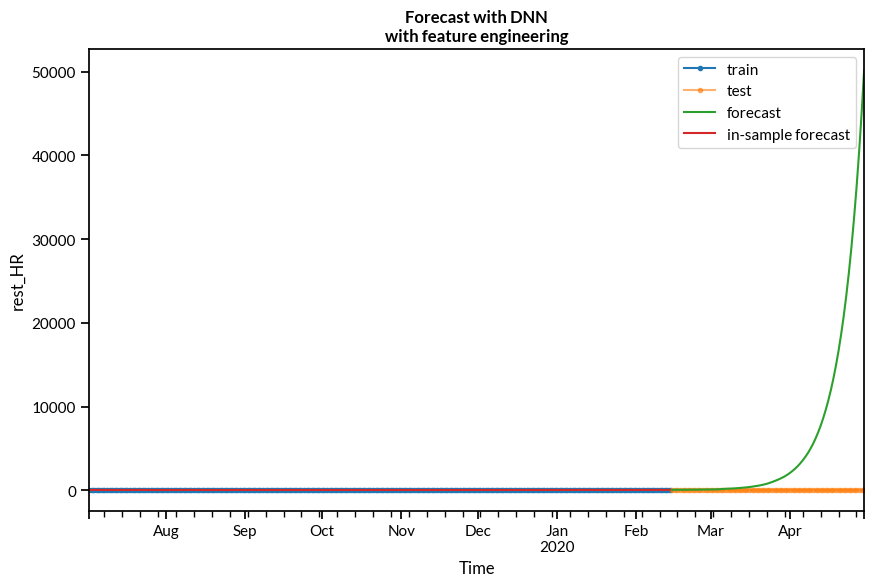

In [125]:
# Compute error metrics
rmse = root_mean_squared_error(y_test.loc[y_forecast.index], y_forecast,)
print(f"{model_dnn.name} | RMSE: {rmse:.3f}")
# performance[model_dnn.name] = rmse
plot_res(y_train, y_test, y_forecast, y_forecast_train, model_dnn.name+'\nwith feature engineering')

DNN | RMSE: 4.874


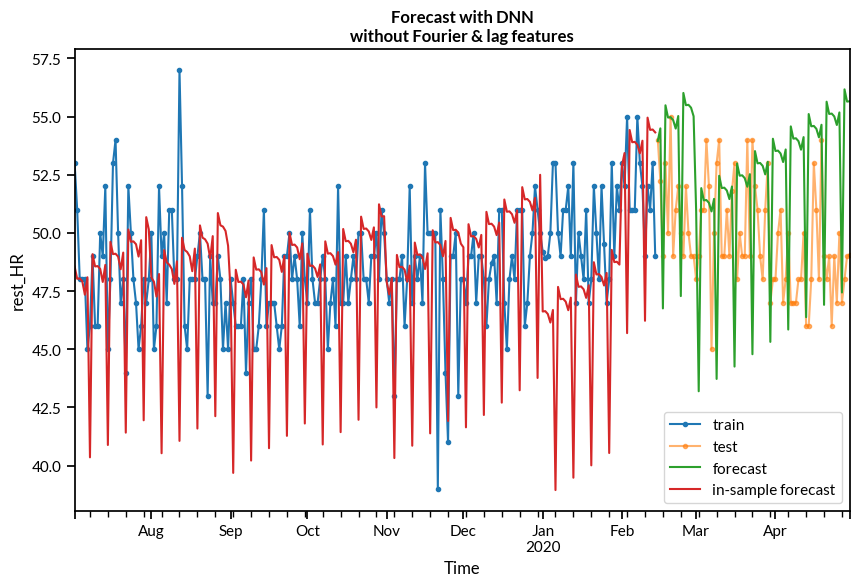

In [148]:
# Compute error metrics
rmse = root_mean_squared_error(y_test.loc[y_forecast.index], y_forecast,)
print(f"{model_dnn.name} | RMSE: {rmse:.3f}")
# performance[model_dnn.name] = rmse
plot_res(y_train, y_test, y_forecast, y_forecast_train, model_dnn.name+'\nwithout Fourier & lag features')

DNN | RMSE: 4.392


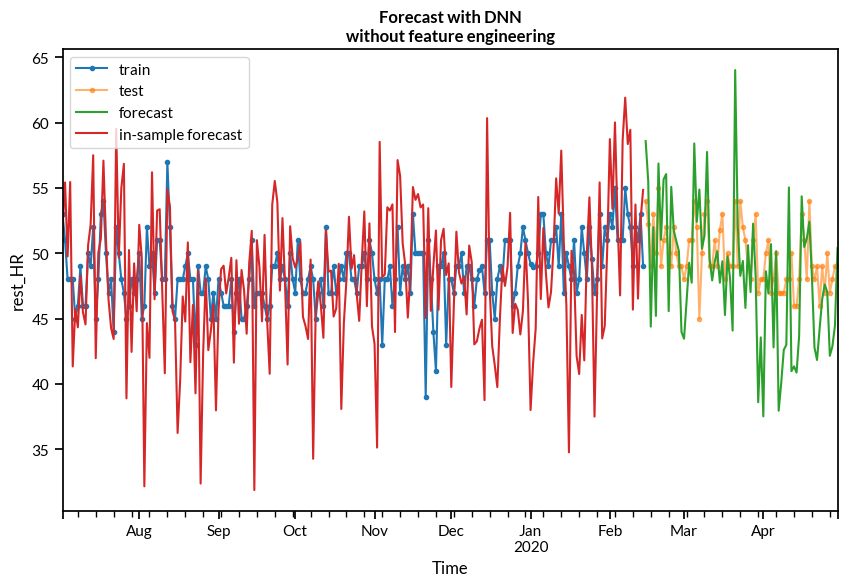

In [159]:
# Compute error metrics
rmse = root_mean_squared_error(y_test.loc[y_forecast.index], y_forecast,)
print(f"{model_dnn.name} | RMSE: {rmse:.3f}")
performance[model_dnn.name] = rmse
plot_res(y_train, y_test, y_forecast, y_forecast_train, model_dnn.name+'\nwithout feature engineering')

#### (2) CNN LSTM

In [10]:
# 1D CNN with LSTM cell
inputs = keras.Input(shape=(X_train.shape[1], X_train.shape[2]))
x = keras.layers.Conv1D(filters=2, kernel_size=1, padding='valid', activation='relu')(inputs)
x = keras.layers.LSTM(4, return_sequences=True, activation='relu')(x)
x = keras.layers.LSTM(4, return_sequences=False, activation='relu')(x)
outputs = keras.layers.Dense(1)(x)
model_cnn = keras.Model(inputs, outputs, name='CNN_LSTM')

model_cnn.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae']
)
model_cnn.summary()

2024-06-18 18:06:49.466499: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-06-18 18:06:49.466540: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-06-18 18:06:49.466574: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-06-18 18:06:49.466790: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-06-18 18:06:49.466811: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "CNN_LSTM"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 1, 3)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 1, 2)           │             8 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 1, 4)           │           112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 4)              │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 269 (1.05 KB)

 Trainable params: 269 (1.05 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
history = model_cnn.fit(
    X_train,
    y_train,
    epochs=60,
    batch_size=4,
)

Epoch 1/60


2024-06-18 18:06:57.156443: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 2367.1807 - mae: 48.5804
Epoch 2/60
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 2374.4175 - mae: 48.6631
Epoch 3/60
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 2332.7986 - mae: 48.2432
Epoch 4/60
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 2271.6807 - mae: 47.5969
Epoch 5/60
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 2172.7969 - mae: 46.5445
Epoch 6/60
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 1783.1873 - mae: 42.0935
Epoch 7/60
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 1144.5680 - mae: 33.5421
Epoch 8/60
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 584.4883 - mae: 23.3681
Epoch 9/60
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 191.4867 - mae: 12.4662
Epoch 10/60
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 76.1463 - mae: 6.8591
Epoch 11/60
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 66.1411 - mae: 6.5911
Epoch 12/60
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 67.1712 - mae: 6.9048
Epoch 13/60

Lowest loss: 59


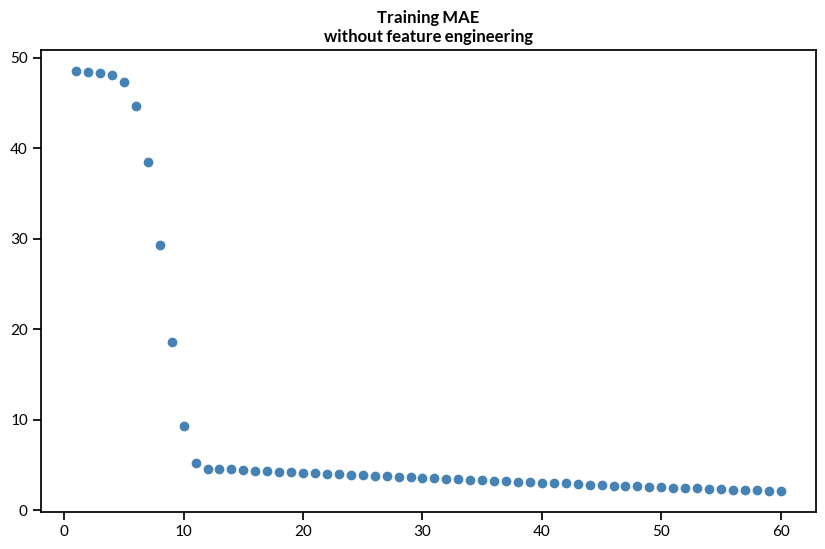

In [39]:
# Plot the result
loss = history.history['mae']
epochs = range(1, len(loss)+1)
plt.figure()
plt.scatter(epochs, loss, marker='o', c=mycolors['blue'], ) # label='Training MAE')
print(f"Lowest loss: {np.argmin(loss)}")
plt.title("Training MAE\nwithout feature engineering");
# plt.legend();

Lowest loss: 59


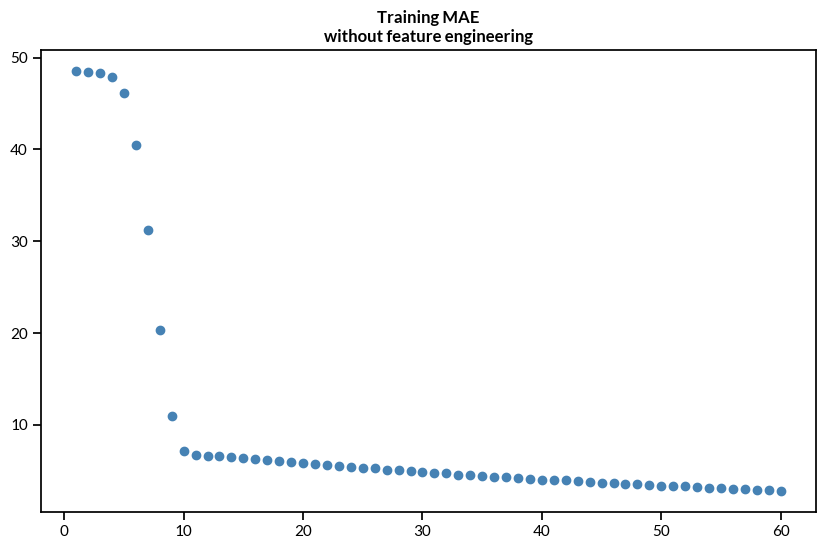

In [12]:
# Plot the result
loss = history.history['mae']
epochs = range(1, len(loss)+1)
plt.figure()
plt.scatter(epochs, loss, marker='o', c=mycolors['blue'], ) # label='Training MAE')
print(f"Lowest loss: {np.argmin(loss)}")
plt.title("Training MAE\nwithout feature engineering");
# plt.legend();

In [13]:
# --- CREATE DYNAMIC PREDICTION DATAFRAME  --- #
look_back_start_time = forecast_start_time - look_back_window_size

# Create `df_predict` which has data going as far back
# as needed to create features which need past values.
df_predict = train_data.loc[look_back_start_time:].copy()

# Extend index into forecast horizon
df_predict = pd.concat([df_predict, pd.DataFrame(index=forecast_horizon)])

df_predict[fs] = df_predict[fs].fillna(test_data)

In [14]:
# --- RECURSIVE FORECASTING LOOP --- #
for forecast_time in forecast_horizon:
    # Compute features during the forecast horizon
    X_test_recur = scaler.transform(df_predict[fs][:forecast_time])
    X_test_ = X_test_recur.loc[[forecast_time]]
    X_test_ = X_test_.values.reshape((X_test_.shape[0], 1, X_test_.shape[1]))

    # Predict one step ahead.
    y_pred = model_cnn.predict(X_test_)

    df_predict.loc[[forecast_time], target_] = y_pred

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━

In [15]:
# --- GET FORECAST AND TEST VALUES --- #
y_forecast = df_predict.loc[forecast_horizon, target_]
# --- CREATE IN-SAMPLE PREDICTIONS--- #
y_forecast_train = model_cnn.predict(X_train)
y_forecast_train = pd.DataFrame(y_forecast_train, index=train_data.index, columns=[target_])

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


CNN_LSTM | RMSE: 3.152


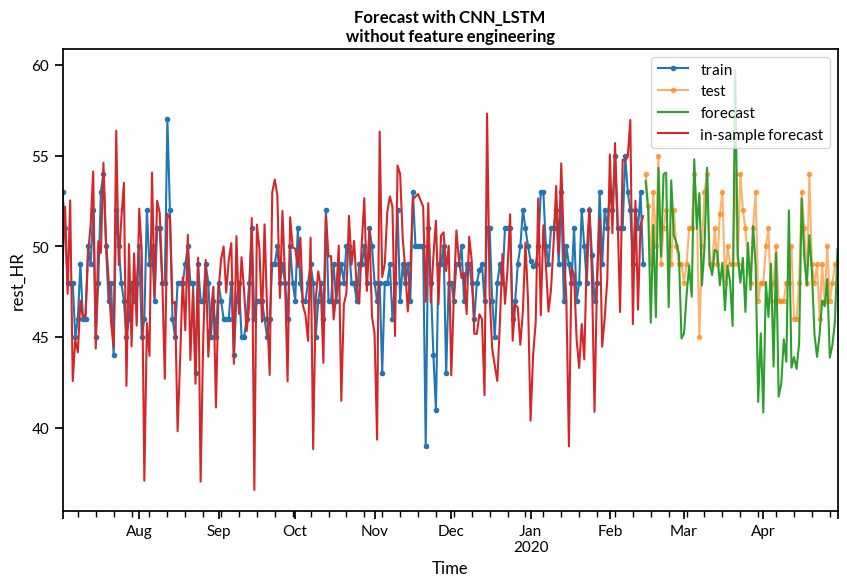

In [26]:
# Compute error metrics
rmse = root_mean_squared_error(y_test.loc[y_forecast.index], y_forecast,)
print(f"{model_cnn.name} | RMSE: {rmse:.3f}")
performance[model_cnn.name] = rmse
plot_res(y_train, y_test, y_forecast, y_forecast_train, model_cnn.name+'\nwithout feature engineering')

#### (3) RNN - LSTM

In [47]:
# LSTM
inputs = keras.Input(shape=(X_train.shape[1], X_train.shape[2]))
x = keras.layers.LSTM(50)(inputs)
outputs = keras.layers.Dense(1)(x)
model_rnn = keras.Model(inputs, outputs, name='LSTM')

model_rnn.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae']
)

history = model_rnn.fit(
    X_train,
    y_train,
    epochs=50,
    batch_size=4
)

Epoch 1/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 2324.2441 - mae: 48.1286
Epoch 2/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2323.9370 - mae: 48.1362
Epoch 3/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2247.3110 - mae: 47.3446
Epoch 4/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2040.9960 - mae: 45.1095
Epoch 5/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1794.7545 - mae: 42.2868
Epoch 6/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1528.7784 - mae: 39.0192
Epoch 7/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1252.9077 - mae: 35.2922
Epoch 8/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 996.3563 - mae: 31.4629
Epoch 9/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 817.7789 - mae: 28.4540
Epoch 10/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 634.3801 - mae: 25.0610
Epoch 11/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 500.8787 - mae: 22.1884
Epoch 12/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 379.5479 - mae: 19.2863
Epoch

Lowest loss: 49


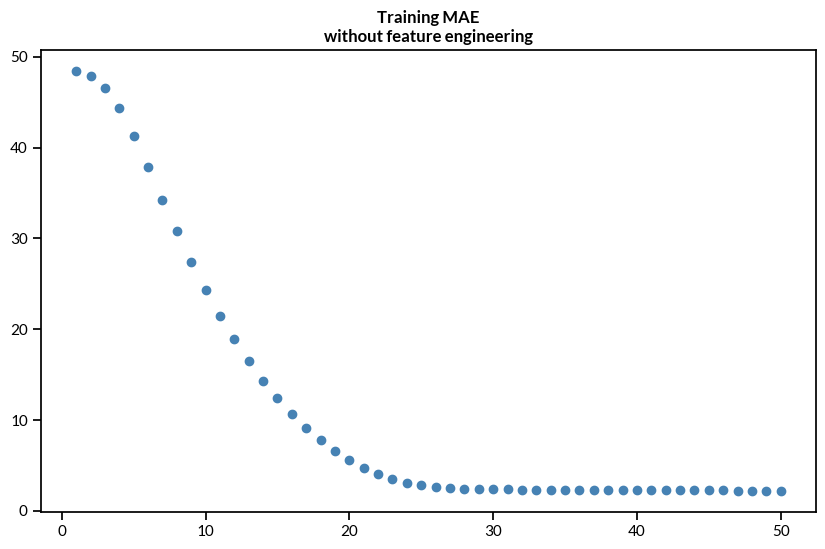

In [48]:
# Plot the result
loss = history.history['mae']
epochs = range(1, len(loss)+1)
plt.figure()
plt.scatter(epochs, loss, marker='o', c=mycolors['blue'], ) # label='Training MAE')
print(f"Lowest loss: {np.argmin(loss)}")
plt.title("Training MAE\nwithout feature engineering");
# plt.legend();

In [49]:
# --- CREATE DYNAMIC PREDICTION DATAFRAME  --- #
look_back_start_time = forecast_start_time - look_back_window_size

# Create `df_predict` which has data going as far back
# as needed to create features which need past values.
df_predict = train_data.loc[look_back_start_time:].copy()

# Extend index into forecast horizon
df_predict = pd.concat([df_predict, pd.DataFrame(index=forecast_horizon)])

df_predict[fs] = df_predict[fs].fillna(test_data)

In [50]:
# --- RECURSIVE FORECASTING LOOP --- #
for forecast_time in forecast_horizon:
    # Compute features during the forecast horizon
    X_test_recur = scaler.transform(df_predict[fs][:forecast_time])
    # print(df_predict[:forecast_time])
    X_test_ = X_test_recur.loc[[forecast_time]]
    X_test_ = X_test_.values.reshape((X_test_.shape[0], 1, X_test_.shape[1]))

    # Predict one step ahead.
    y_pred = model_rnn.predict(X_test_)

    # Append forecast to the target variable columnn in our
    # dynamic forecast dataframe `df_predict`. This `df_predict`
    # is ready for the next iteration where we will re-compute
    # features derived from the target such as lags and windows.
    df_predict.loc[[forecast_time], target_] = y_pred

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━

In [51]:
# --- GET FORECAST AND TEST VALUES --- #
y_forecast = df_predict.loc[forecast_horizon, target_]
# --- CREATE IN-SAMPLE PREDICTIONS--- #
y_forecast_train = model_rnn.predict(X_train)
y_forecast_train = pd.DataFrame(y_forecast_train, index=train_data.index, columns=[target_])

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step  


LSTM | RMSE: 2.310


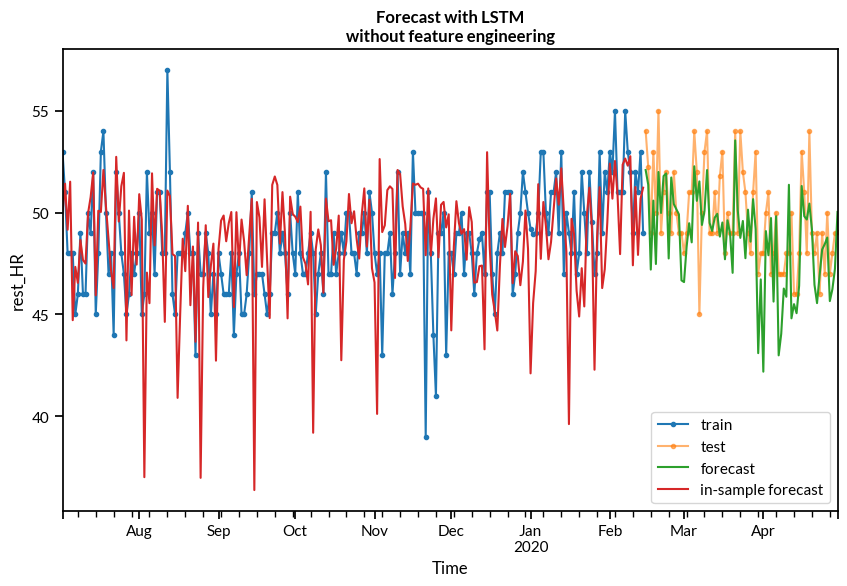

In [52]:
# Compute error metrics
rmse = root_mean_squared_error(y_test.loc[y_forecast.index], y_forecast,)
print(f"{model_rnn.name} | RMSE: {rmse:.3f}")
performance[model_rnn.name] = rmse
plot_res(y_train, y_test, y_forecast, y_forecast_train, model_rnn.name+'\nwithout feature engineering') 

## <font color = deepskyblue>IV. Conlusion</font>

1. **Deep Learning for Limited Data:** 

    Our results suggest that for tasks with limited data and relatively simple underlying relationships, simpler models like linear regression might be more efficient than deep learning approaches. While LSTM performed best among the deep learning models, it was still surpassed by linear regression. This highlights __the importance of considering data characteristics and problem complexity when choosing machine learning models__. 

2. **Predictability of Resting Heart Rate:** 

    The achieved RMSE of around 1.4 bpm indicates a good fit between predicted and actual resting heart rates. This suggests that resting heart rate can be predicted with reasonable accuracy using the proposed approach. 

3. **Future Work:**

    *  **Generalizability with More Data:**  
    
        Currently, the analysis is based on data from a single individual. In future work, it would be beneficial to collect data from a broader population to assess the generalizability of our methods.
    
    *  **Exploring Feature Engineering:**  
    
        We explored feature engineering techniques like time-based features and lag features. Future work could investigate the impact of incorporating additional features or using different feature engineering approaches.
    
    *  **Model Exploration:**  
    
        While this project focused on linear regression and deep learning models, exploring other machine learning models could be valuable for comparison and potentially lead to even better performance.

4. **Reference**

    * [Multivariate Time Series Forecasting with LSTMs in Keras](https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/)

    * [Time Series Forecasting: Building Intuition](https://www.kaggle.com/code/iamleonie/time-series-forecasting-building-intuition#Introduction)

    * [Tensorflow - Time series forecasting](https://www.tensorflow.org/tutorials/structured_data/time_series)

    * [How to Develop LSTM Models for Time Series Forecasting](https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/)

    * [Online Course - Feature Engineering for Time Series Forecasting](https://www.trainindata.com/)


In [27]:
# Get RMSE
df_ = pd.DataFrame(performance, index=[0]).round(4)
df_ = df_.sort_values(by=0, axis=1)
df_

,Lasso,LinearRegression,Ridge,LSTM,CNN_LSTM,DNN
0,1.4285,1.4942,1.5219,2.5976,3.1518,4.3925


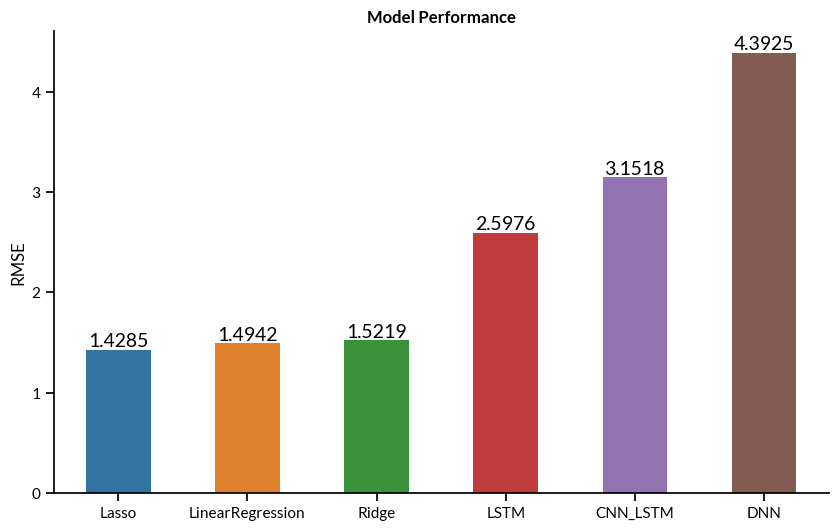

In [28]:
# Plot the RMSE
fig, ax = plt.subplots()
sns.barplot(df_, width=.5, ax=ax)

ax.set_title('Model Performance')
ax.set_ylabel('RMSE')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# Add text
for i in ax.containers:
    ax.bar_label(i,);